In [6]:
import torch

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Task#1

2 convolution layers, 1 full connected, Sigmoid Activation function, Max pooling

Using device: cuda
Epoch [1/25], Train Loss: 4.4265, Train Accuracy: 1.29%, Test Loss: 4.4129, Test Accuracy: 1.41%
Epoch [2/25], Train Loss: 4.4203, Train Accuracy: 1.26%, Test Loss: 4.4005, Test Accuracy: 1.90%
Epoch [3/25], Train Loss: 4.3937, Train Accuracy: 1.53%, Test Loss: 4.3818, Test Accuracy: 1.66%
Epoch [4/25], Train Loss: 4.3813, Train Accuracy: 1.78%, Test Loss: 4.3772, Test Accuracy: 2.33%
Epoch [5/25], Train Loss: 4.3752, Train Accuracy: 2.19%, Test Loss: 4.3753, Test Accuracy: 3.01%
Epoch [6/25], Train Loss: 4.3704, Train Accuracy: 2.46%, Test Loss: 4.3717, Test Accuracy: 2.70%
Epoch [7/25], Train Loss: 4.3642, Train Accuracy: 2.76%, Test Loss: 4.3682, Test Accuracy: 2.58%
Epoch [8/25], Train Loss: 4.3599, Train Accuracy: 2.93%, Test Loss: 4.3671, Test Accuracy: 3.81%
Epoch [9/25], Train Loss: 4.3558, Train Accuracy: 2.90%, Test Loss: 4.3616, Test Accuracy: 2.52%
Epoch [10/25], Train Loss: 4.3525, Train Accuracy: 3.16%, Test Loss: 4.3600, Test Accuracy: 3.19%
Epoch [11/

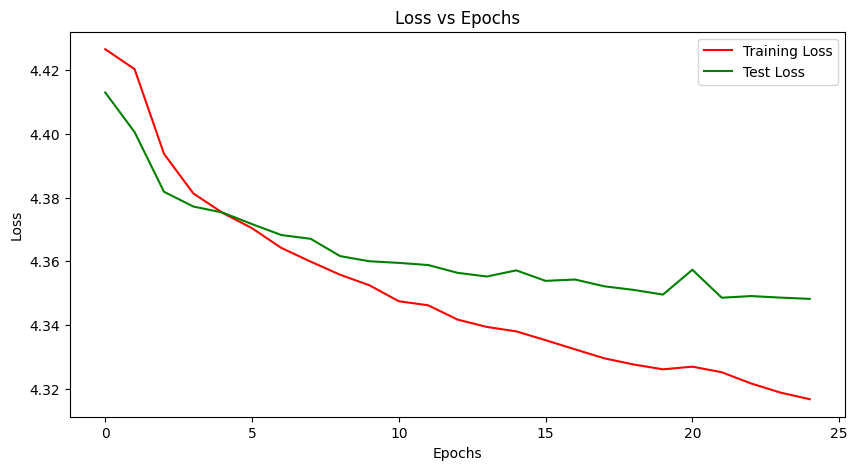

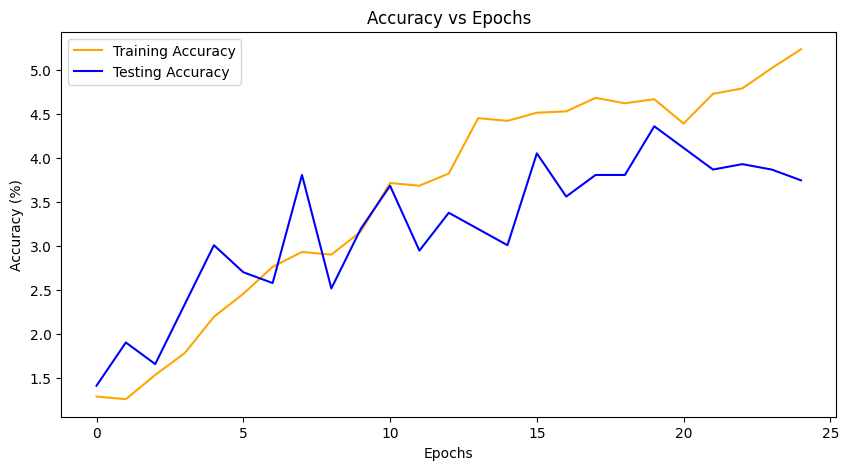

Final Test Loss: 4.3482, Final Test Accuracy: 3.74%
True: user001, Predicted: user001
True: user001, Predicted: user011
True: user001, Predicted: user025
True: user001, Predicted: user069
True: user001, Predicted: user050
True: user001, Predicted: user073
True: user001, Predicted: user005
True: user001, Predicted: user023
True: user001, Predicted: user023
True: user001, Predicted: user071
True: user001, Predicted: user002
True: user001, Predicted: user022
True: user001, Predicted: user056
True: user001, Predicted: user037
True: user001, Predicted: user037
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user073
True: user001, Predicted: user046
True: user001, Predicted: user064
True: user002, Predicted: user004
True: user002, Predicted: user004
True: user002, Predicted: user028
True: user002, Predicted: user075
True: user002, Predicted: user021
True: user002, Predicted: user028
True: user002, Predicted: user050
True: user002, Predicted: user

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)

        # Placeholder for the fully connected layer
        self.fc1 = None
        self.flatten_size = None

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.sigmoid(self.bn1(self.conv1(x))))
        x = self.pool(torch.sigmoid(self.bn2(self.conv2(x))))
        
        # Dynamically initialize the fully connected layer
        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flatten_size, num_classes).to(x.device)
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layer
        x = self.fc1(x)
        return x


# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")
                
# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")

2 convolution layers, 1 full connected, RELU Activation function, Max pooling

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)

        # Placeholder for the fully connected layer
        self.fc1 = None
        self.flatten_size = None

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.tanh(self.bn1(self.conv1(x))))
        x = self.pool(torch.tanh(self.bn2(self.conv2(x))))
        
        # Dynamically initialize the fully connected layer
        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flatten_size, num_classes).to(x.device)
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layer
        x = self.fc1(x)
        return x


# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")
                
# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")

2 convolution layers, 1 full connected, RELU Activation function, Max pooling

Using device: cuda
Epoch [1/25], Train Loss: 4.4283, Train Accuracy: 1.77%, Test Loss: 4.3765, Test Accuracy: 2.33%
Epoch [2/25], Train Loss: 4.3877, Train Accuracy: 2.15%, Test Loss: 4.3768, Test Accuracy: 2.09%
Epoch [3/25], Train Loss: 4.3632, Train Accuracy: 2.70%, Test Loss: 4.3612, Test Accuracy: 2.21%
Epoch [4/25], Train Loss: 4.3421, Train Accuracy: 3.13%, Test Loss: 4.3423, Test Accuracy: 3.07%
Epoch [5/25], Train Loss: 4.3253, Train Accuracy: 3.44%, Test Loss: 4.3243, Test Accuracy: 3.07%
Epoch [6/25], Train Loss: 4.3034, Train Accuracy: 3.55%, Test Loss: 4.3210, Test Accuracy: 3.07%
Epoch [7/25], Train Loss: 4.2816, Train Accuracy: 3.81%, Test Loss: 4.3114, Test Accuracy: 3.44%
Epoch [8/25], Train Loss: 4.2668, Train Accuracy: 4.01%, Test Loss: 4.2935, Test Accuracy: 3.38%
Epoch [9/25], Train Loss: 4.2529, Train Accuracy: 4.41%, Test Loss: 4.2934, Test Accuracy: 3.38%
Epoch [10/25], Train Loss: 4.2371, Train Accuracy: 4.16%, Test Loss: 4.2782, Test Accuracy: 3.93%
Epoch [11/

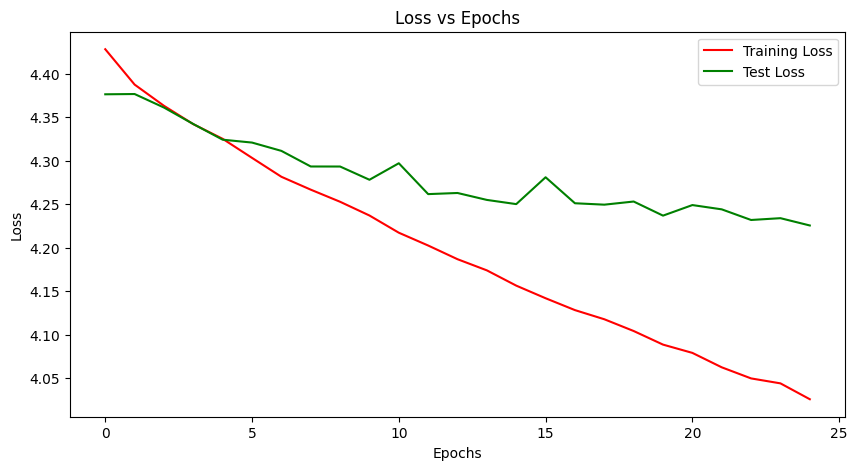

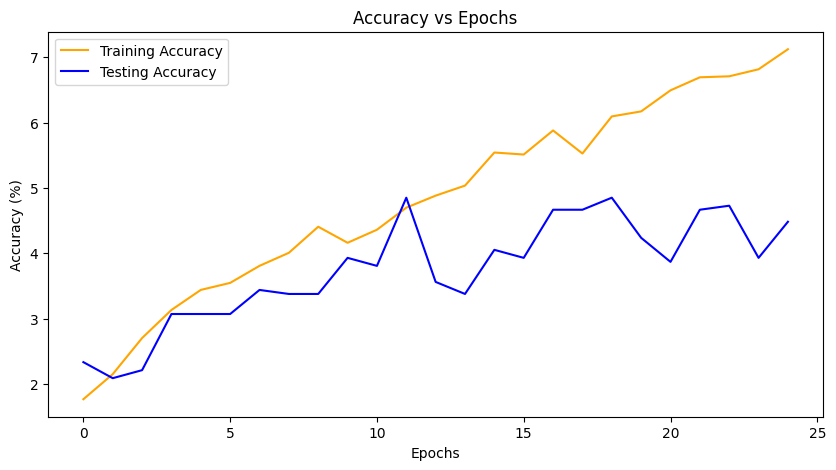

Final Test Loss: 4.2256, Final Test Accuracy: 4.48%
True: user001, Predicted: user025
True: user001, Predicted: user001
True: user001, Predicted: user026
True: user001, Predicted: user002
True: user001, Predicted: user078
True: user001, Predicted: user017
True: user001, Predicted: user001
True: user001, Predicted: user046
True: user001, Predicted: user009
True: user001, Predicted: user010
True: user001, Predicted: user077
True: user001, Predicted: user043
True: user001, Predicted: user058
True: user001, Predicted: user011
True: user001, Predicted: user045
True: user001, Predicted: user003
True: user001, Predicted: user001
True: user001, Predicted: user073
True: user001, Predicted: user007
True: user001, Predicted: user077
True: user002, Predicted: user063
True: user002, Predicted: user022
True: user002, Predicted: user008
True: user002, Predicted: user063
True: user002, Predicted: user020
True: user002, Predicted: user002
True: user002, Predicted: user080
True: user002, Predicted: user

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)

        # Placeholder for the fully connected layer
        self.fc1 = None
        self.flatten_size = None

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        # Dynamically initialize the fully connected layer
        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flatten_size, num_classes).to(x.device)
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layer
        x = self.fc1(x)
        return x


# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")
                
# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")

3 convolution layers, 1 full connected, RELU Activation function, Max pooling

Using device: cuda
Epoch [1/25], Train Loss: 4.3256, Train Accuracy: 2.46%, Test Loss: 4.2121, Test Accuracy: 3.81%
Epoch [2/25], Train Loss: 4.1171, Train Accuracy: 5.08%, Test Loss: 4.0431, Test Accuracy: 5.65%
Epoch [3/25], Train Loss: 3.9310, Train Accuracy: 8.01%, Test Loss: 3.9750, Test Accuracy: 7.67%
Epoch [4/25], Train Loss: 3.7891, Train Accuracy: 10.84%, Test Loss: 3.9443, Test Accuracy: 7.31%
Epoch [5/25], Train Loss: 3.6418, Train Accuracy: 13.05%, Test Loss: 3.8931, Test Accuracy: 8.72%
Epoch [6/25], Train Loss: 3.4912, Train Accuracy: 16.18%, Test Loss: 3.8715, Test Accuracy: 9.88%
Epoch [7/25], Train Loss: 3.3507, Train Accuracy: 18.88%, Test Loss: 3.9003, Test Accuracy: 10.87%
Epoch [8/25], Train Loss: 3.1666, Train Accuracy: 22.89%, Test Loss: 3.9274, Test Accuracy: 11.17%
Epoch [9/25], Train Loss: 3.0023, Train Accuracy: 26.19%, Test Loss: 3.9683, Test Accuracy: 11.05%
Epoch [10/25], Train Loss: 2.8275, Train Accuracy: 28.93%, Test Loss: 3.9913, Test Accuracy: 11.48%

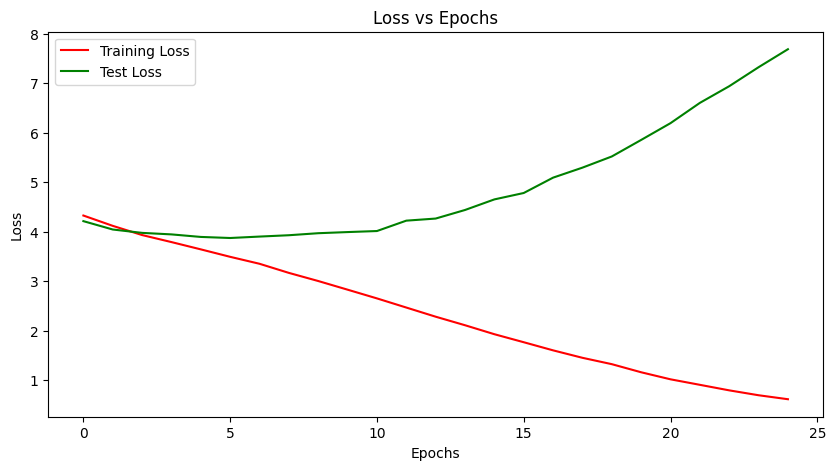

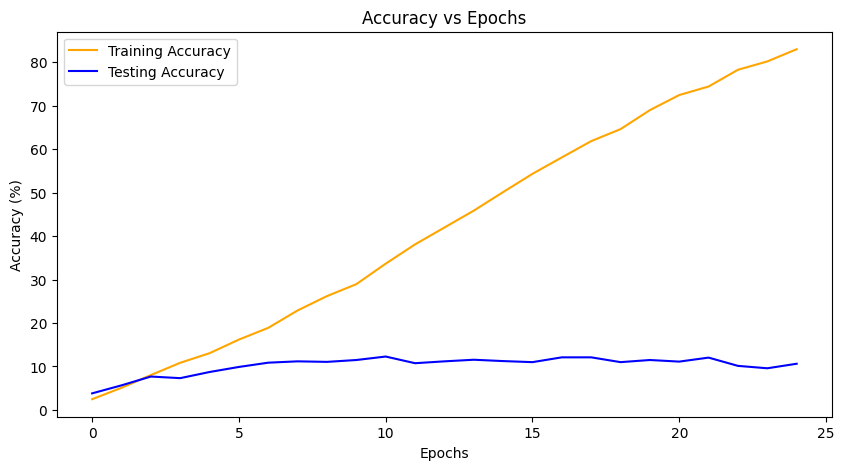

Final Test Loss: 7.6855, Final Test Accuracy: 10.62%
True: user001, Predicted: user042
True: user001, Predicted: user068
True: user001, Predicted: user001
True: user001, Predicted: user029
True: user001, Predicted: user009
True: user001, Predicted: user025
True: user001, Predicted: user025
True: user001, Predicted: user073
True: user001, Predicted: user007
True: user001, Predicted: user006
True: user001, Predicted: user033
True: user001, Predicted: user062
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user025
True: user001, Predicted: user081
True: user001, Predicted: user008
True: user001, Predicted: user015
True: user001, Predicted: user001
True: user001, Predicted: user062
True: user002, Predicted: user073
True: user002, Predicted: user034
True: user002, Predicted: user002
True: user002, Predicted: user037
True: user002, Predicted: user081
True: user002, Predicted: user035
True: user002, Predicted: user064
True: user002, Predicted: use

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Third convolution layer
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization for third layer

        # Placeholder for the fully connected layer
        self.fc1 = None
        self.flatten_size = None

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))  # Apply third convolution
        
        # Dynamically initialize the fully connected layer
        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flatten_size, num_classes).to(x.device)
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layer
        x = self.fc1(x)
        return x


# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")
                
# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")


4 convolution layers, 1 full connected, RELU Activation function, Max pooling

Using device: cuda
Epoch [1/25], Train Loss: 4.1166, Train Accuracy: 7.01%, Test Loss: 3.8939, Test Accuracy: 8.53%
Epoch [2/25], Train Loss: 3.5262, Train Accuracy: 15.24%, Test Loss: 3.2775, Test Accuracy: 18.97%
Epoch [3/25], Train Loss: 2.7846, Train Accuracy: 30.53%, Test Loss: 3.0422, Test Accuracy: 27.26%
Epoch [4/25], Train Loss: 2.1386, Train Accuracy: 44.51%, Test Loss: 2.8758, Test Accuracy: 29.90%
Epoch [5/25], Train Loss: 1.4967, Train Accuracy: 60.63%, Test Loss: 2.9366, Test Accuracy: 32.17%
Epoch [6/25], Train Loss: 0.9067, Train Accuracy: 75.17%, Test Loss: 3.3645, Test Accuracy: 33.82%
Epoch [7/25], Train Loss: 0.4860, Train Accuracy: 86.09%, Test Loss: 3.8775, Test Accuracy: 31.61%
Epoch [8/25], Train Loss: 0.2774, Train Accuracy: 91.40%, Test Loss: 4.3261, Test Accuracy: 31.98%
Epoch [9/25], Train Loss: 0.1923, Train Accuracy: 94.27%, Test Loss: 4.9122, Test Accuracy: 34.75%
Epoch [10/25], Train Loss: 0.1197, Train Accuracy: 96.41%, Test Loss: 5.3935, Test Accuracy:

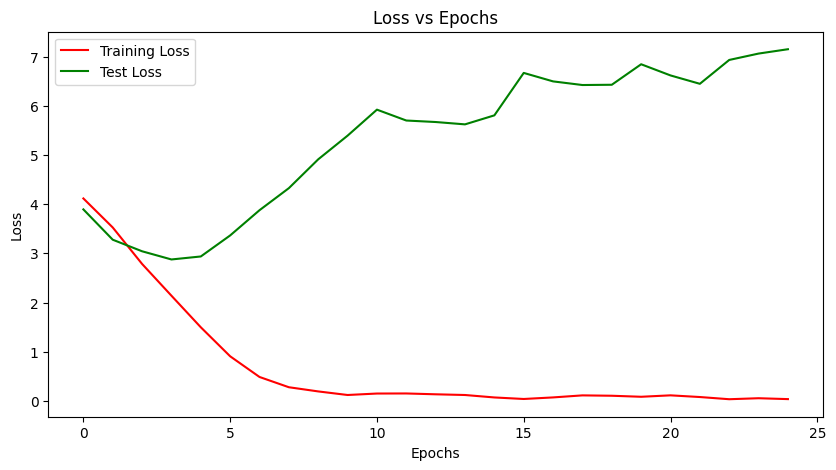

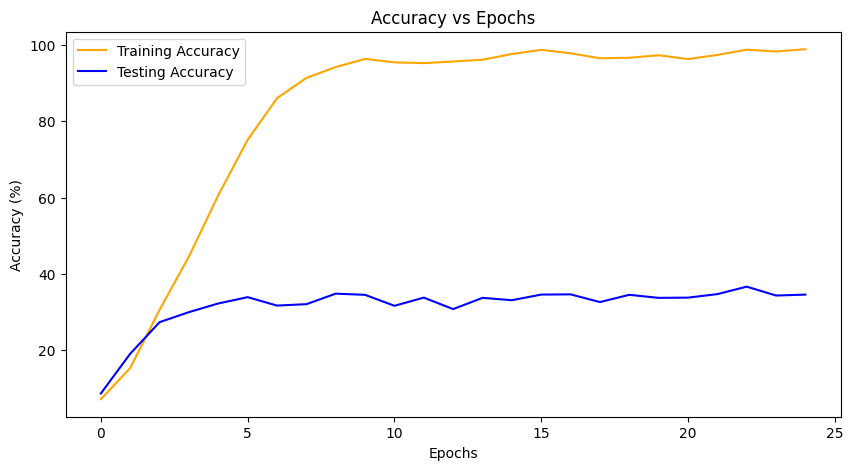

Final Test Loss: 7.1511, Final Test Accuracy: 34.50%
True: user001, Predicted: user001
True: user001, Predicted: user008
True: user001, Predicted: user001
True: user001, Predicted: user071
True: user001, Predicted: user005
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user061
True: user001, Predicted: user007
True: user001, Predicted: user016
True: user001, Predicted: user069
True: user001, Predicted: user080
True: user001, Predicted: user077
True: user001, Predicted: user007
True: user001, Predicted: user032
True: user001, Predicted: user056
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user048
True: user001, Predicted: user048
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user078
True: user002, Predicted: user002
True: user002, Predicted: user042
True: user002, Predicted: use

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Third convolution layer
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # Fourth convolution layer
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization for third layer
        self.bn4 = nn.BatchNorm2d(256)  # Batch normalization for fourth layer

        # Placeholder for the fully connected layer
        self.fc1 = None
        self.flatten_size = None

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))  # Apply third convolution
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))  # Apply fourth convolution
        
        # Dynamically initialize the fully connected layer
        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flatten_size, num_classes).to(x.device)
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layer
        x = self.fc1(x)
        return x


# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")
                
# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")


4 convolution layers, 2 full connected, RELU Activation function, Max pooling

Using device: cuda
Epoch [1/25], Train Loss: 4.3515, Train Accuracy: 3.25%, Test Loss: 4.2388, Test Accuracy: 5.16%
Epoch [2/25], Train Loss: 3.8813, Train Accuracy: 10.18%, Test Loss: 3.6706, Test Accuracy: 11.17%
Epoch [3/25], Train Loss: 3.2686, Train Accuracy: 20.35%, Test Loss: 3.2957, Test Accuracy: 20.14%
Epoch [4/25], Train Loss: 2.7250, Train Accuracy: 32.22%, Test Loss: 3.1607, Test Accuracy: 24.06%
Epoch [5/25], Train Loss: 2.2406, Train Accuracy: 42.06%, Test Loss: 3.0680, Test Accuracy: 27.44%
Epoch [6/25], Train Loss: 1.7189, Train Accuracy: 54.57%, Test Loss: 3.1997, Test Accuracy: 27.56%
Epoch [7/25], Train Loss: 1.2244, Train Accuracy: 66.09%, Test Loss: 3.3224, Test Accuracy: 30.33%
Epoch [8/25], Train Loss: 0.7462, Train Accuracy: 78.83%, Test Loss: 3.7260, Test Accuracy: 30.33%
Epoch [9/25], Train Loss: 0.4323, Train Accuracy: 87.41%, Test Loss: 4.3197, Test Accuracy: 30.69%
Epoch [10/25], Train Loss: 0.2843, Train Accuracy: 91.36%, Test Loss: 4.8948, Test Accuracy:

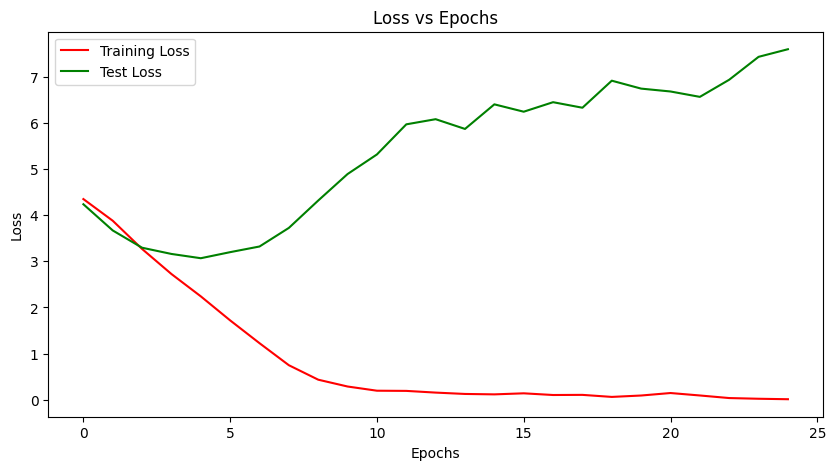

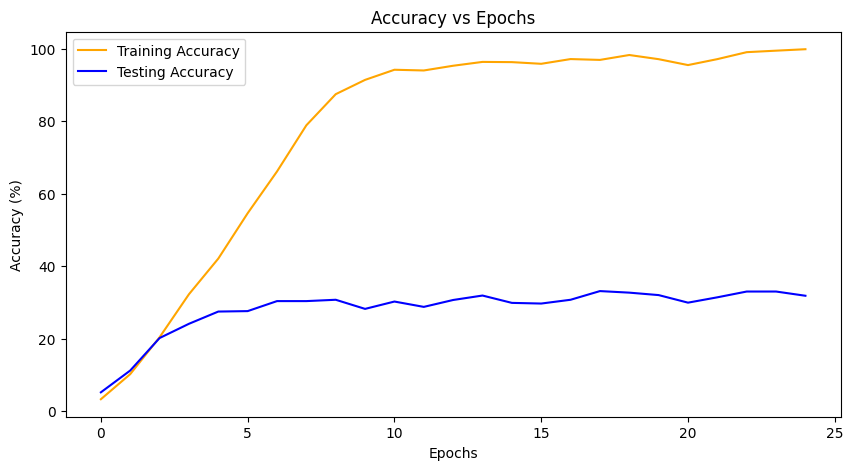

Final Test Loss: 7.6028, Final Test Accuracy: 31.80%
True: user001, Predicted: user001
True: user001, Predicted: user016
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user013
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user034
True: user001, Predicted: user004
True: user001, Predicted: user071
True: user001, Predicted: user004
True: user001, Predicted: user019
True: user001, Predicted: user069
True: user001, Predicted: user001
True: user001, Predicted: user056
True: user001, Predicted: user011
True: user001, Predicted: user001
True: user001, Predicted: user073
True: user001, Predicted: user001
True: user001, Predicted: user013
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user063
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: use

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Third convolution layer
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # Fourth convolution layer
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization for third layer
        self.bn4 = nn.BatchNorm2d(256)  # Batch normalization for fourth layer

        # Placeholder for the fully connected layers
        self.fc1 = None
        self.fc2 = None
        self.flatten_size = None

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))  # Apply third convolution
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))  # Apply fourth convolution
        
        # Dynamically initialize the fully connected layers
        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flatten_size, 512).to(x.device)  # First fully connected layer
            self.fc2 = nn.Linear(512, num_classes).to(x.device)  # Second fully connected layer
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers with dropout
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")
                
# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")


4 convolution layers, 3 full connected, RELU Activation function, AVG pooling

Epoch [1/25], Train Loss: 4.0760, Train Accuracy: 5.30%, Test Loss: 22.0022, Test Accuracy: 1.23%
Epoch [2/25], Train Loss: 3.9638, Train Accuracy: 7.84%, Test Loss: 3.3948, Test Accuracy: 14.55%
Epoch [3/25], Train Loss: 3.1269, Train Accuracy: 18.77%, Test Loss: 3.0316, Test Accuracy: 21.49%
Epoch [4/25], Train Loss: 2.7774, Train Accuracy: 24.48%, Test Loss: 2.8566, Test Accuracy: 25.17%
Epoch [5/25], Train Loss: 2.5104, Train Accuracy: 30.35%, Test Loss: 2.7722, Test Accuracy: 25.35%
Epoch [6/25], Train Loss: 2.2867, Train Accuracy: 35.13%, Test Loss: 2.6473, Test Accuracy: 28.97%
Epoch [7/25], Train Loss: 2.0760, Train Accuracy: 40.60%, Test Loss: 2.5258, Test Accuracy: 32.11%
Epoch [8/25], Train Loss: 1.8564, Train Accuracy: 46.23%, Test Loss: 2.6356, Test Accuracy: 31.18%
Epoch [9/25], Train Loss: 1.6517, Train Accuracy: 51.79%, Test Loss: 2.6314, Test Accuracy: 32.47%
Epoch [10/25], Train Loss: 1.4908, Train Accuracy: 56.13%, Test Loss: 2.7860, Test Accuracy: 33.46%
Epoch [11/2

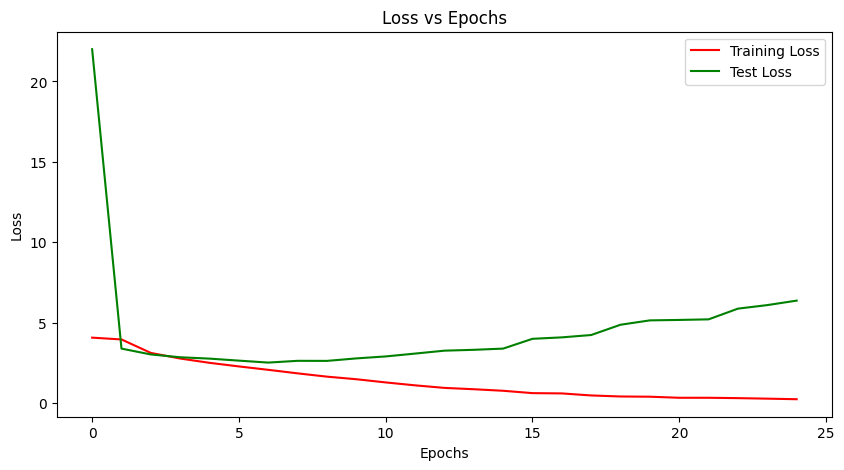

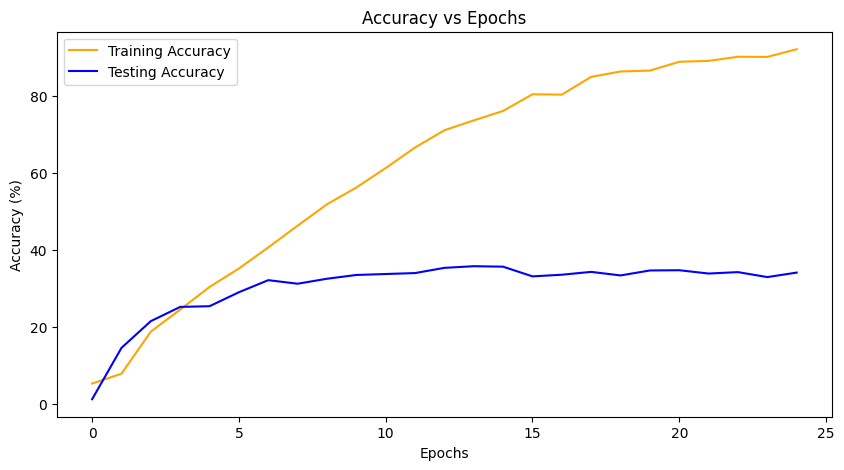

Final Test Loss: 6.3772, Final Test Accuracy: 34.07%
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user008
True: user001, Predicted: user060
True: user001, Predicted: user011
True: user001, Predicted: user025
True: user001, Predicted: user001
True: user001, Predicted: user006
True: user001, Predicted: user004
True: user001, Predicted: user029
True: user001, Predicted: user055
True: user001, Predicted: user001
True: user001, Predicted: user035
True: user001, Predicted: user001
True: user001, Predicted: user025
True: user001, Predicted: user011
True: user001, Predicted: user025
True: user001, Predicted: user034
True: user001, Predicted: user001
True: user001, Predicted: user004
True: user002, Predicted: user037
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user018
True: user002, Predicted: user021
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: use

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the Custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
         
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 9 * 9, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations (no augmentation)
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize all images to 150x150
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()


# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=25)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")

L2 regularization ADDED to DECREASE Overfitting and drop out = 0.3

Epoch [1/15], Train Loss: 3.9597, Train Accuracy: 4.97%, Test Loss: 3.9595, Test Accuracy: 6.02%
Epoch [2/15], Train Loss: 3.9856, Train Accuracy: 6.23%, Test Loss: 3.6009, Test Accuracy: 8.59%
Epoch [3/15], Train Loss: 3.3085, Train Accuracy: 13.97%, Test Loss: 3.1518, Test Accuracy: 15.29%
Epoch [4/15], Train Loss: 2.9213, Train Accuracy: 20.09%, Test Loss: 2.9518, Test Accuracy: 22.47%
Epoch [5/15], Train Loss: 2.6496, Train Accuracy: 25.31%, Test Loss: 2.6549, Test Accuracy: 24.98%
Epoch [6/15], Train Loss: 2.4342, Train Accuracy: 30.91%, Test Loss: 2.5558, Test Accuracy: 27.56%
Epoch [7/15], Train Loss: 2.2511, Train Accuracy: 34.86%, Test Loss: 2.4692, Test Accuracy: 31.18%
Epoch [8/15], Train Loss: 2.0290, Train Accuracy: 39.34%, Test Loss: 2.4259, Test Accuracy: 33.33%
Epoch [9/15], Train Loss: 1.8202, Train Accuracy: 45.07%, Test Loss: 2.3080, Test Accuracy: 37.02%
Epoch [10/15], Train Loss: 1.6106, Train Accuracy: 50.65%, Test Loss: 2.3892, Test Accuracy: 35.54%
Epoch [11/15]

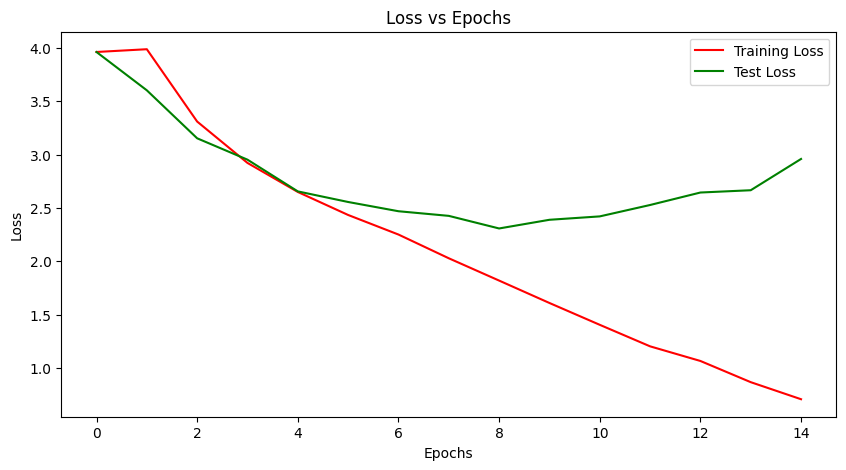

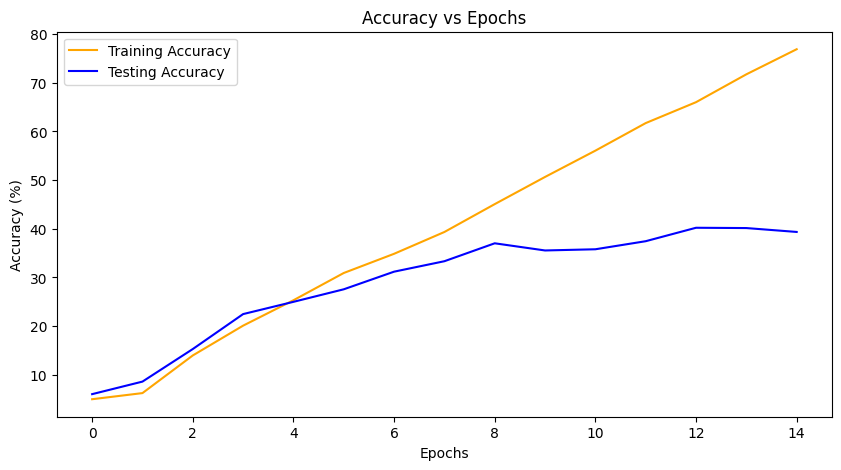

Final Test Loss: 2.9585, Final Test Accuracy: 39.35%
True: user001, Predicted: user008
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user008
True: user001, Predicted: user025
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user011
True: user001, Predicted: user031
True: user001, Predicted: user010
True: user001, Predicted: user001
True: user001, Predicted: user032
True: user001, Predicted: user001
True: user001, Predicted: user011
True: user001, Predicted: user043
True: user001, Predicted: user001
True: user001, Predicted: user080
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user002, Predicted: user013
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user040
True: user002, Predicted: user021
True: user002, Predicted: user002
True: user002, Predicted: user060
True: user002, Predicted: use

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Calculate the flattened size dynamically
        dummy_input = torch.zeros(1, 3, 150, 150)  # Dummy input with input image size
        self.feature_map_size = self._get_flatten_size(dummy_input)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flatten_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations (no augmentation)
transform = transforms.Compose([

    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer with L2 regularization
weight_decay = 1e-4  # You can change this value to adjust the regularization strength
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")


Epoch [1/15], Train Loss: 4.2580, Train Accuracy: 2.39%, Test Loss: 7.0012, Test Accuracy: 2.09%
Epoch [2/15], Train Loss: 4.0500, Train Accuracy: 4.70%, Test Loss: 3.7229, Test Accuracy: 7.98%
Epoch [3/15], Train Loss: 3.5228, Train Accuracy: 10.27%, Test Loss: 3.3708, Test Accuracy: 12.40%
Epoch [4/15], Train Loss: 3.1949, Train Accuracy: 14.75%, Test Loss: 3.1620, Test Accuracy: 15.78%
Epoch [5/15], Train Loss: 2.9359, Train Accuracy: 20.00%, Test Loss: 2.9650, Test Accuracy: 20.07%
Epoch [6/15], Train Loss: 2.6808, Train Accuracy: 25.43%, Test Loss: 2.8649, Test Accuracy: 23.57%
Epoch [7/15], Train Loss: 2.3821, Train Accuracy: 31.28%, Test Loss: 2.6252, Test Accuracy: 26.52%
Epoch [8/15], Train Loss: 2.1188, Train Accuracy: 37.47%, Test Loss: 2.4846, Test Accuracy: 32.17%
Epoch [9/15], Train Loss: 1.8463, Train Accuracy: 44.60%, Test Loss: 2.4826, Test Accuracy: 32.78%
Epoch [10/15], Train Loss: 1.5927, Train Accuracy: 50.85%, Test Loss: 2.4256, Test Accuracy: 36.46%
Epoch [11/15]

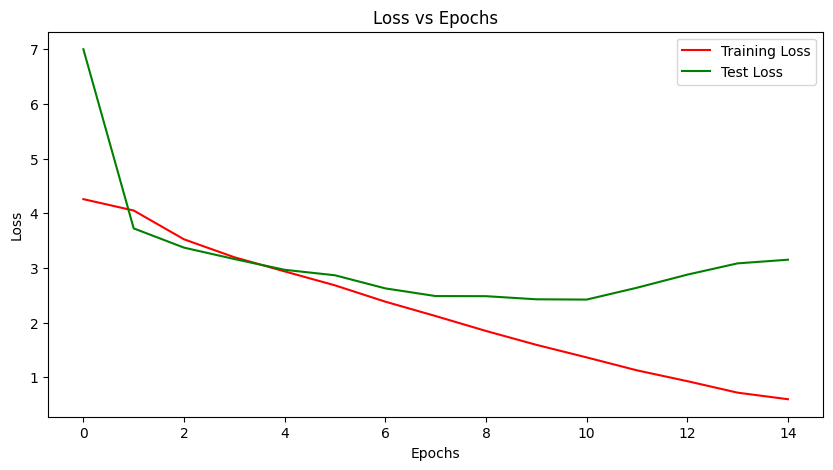

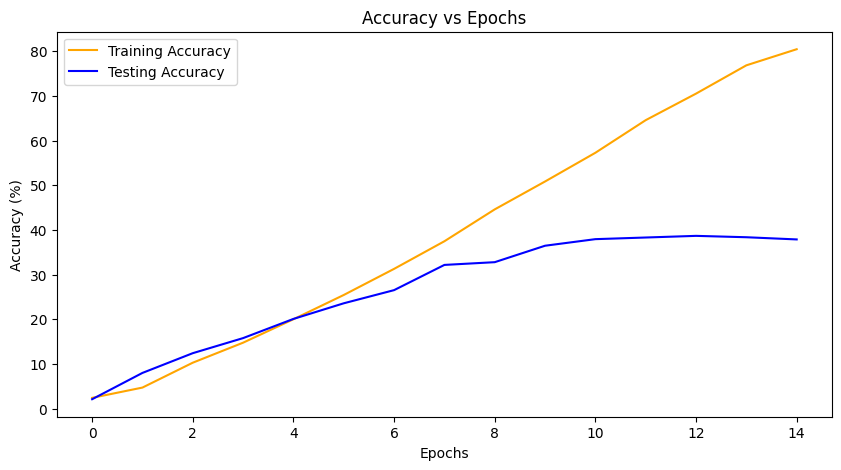

Final Test Loss: 3.1497, Final Test Accuracy: 37.88%
True: user001, Predicted: user001
True: user001, Predicted: user008
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user008
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user009
True: user001, Predicted: user001
True: user001, Predicted: user011
True: user001, Predicted: user081
True: user001, Predicted: user014
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user009
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user008
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: use

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.7)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Calculate the flattened size dynamically
        dummy_input = torch.zeros(1, 3, 150, 150)  # Dummy input with input image size
        self.feature_map_size = self._get_flatten_size(dummy_input)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flatten_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations (no augmentation)
transform = transforms.Compose([

    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer with L2 regularization
weight_decay = 1e-4  # You can change this value to adjust the regularization strength
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")


######### our CNN FINAL MODEL #########

#TASK 2

WITHOUT DATA AUGMENTATION

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Calculate the flattened size dynamically
        dummy_input = torch.zeros(1, 3, 150, 150)  # Dummy input with input image size
        self.feature_map_size = self._get_flatten_size(dummy_input)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flatten_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations (no augmentation)
transform = transforms.Compose([
    

    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")

WITH AUGMENTATION

Epoch [1/15], Train Loss: 4.3949, Train Accuracy: 1.29%, Test Loss: 4.1820, Test Accuracy: 3.62%
Epoch [2/15], Train Loss: 4.1078, Train Accuracy: 3.51%, Test Loss: 4.1350, Test Accuracy: 5.34%
Epoch [3/15], Train Loss: 3.8769, Train Accuracy: 5.51%, Test Loss: 4.1311, Test Accuracy: 5.16%
Epoch [4/15], Train Loss: 3.7352, Train Accuracy: 7.14%, Test Loss: 4.5771, Test Accuracy: 3.74%
Epoch [5/15], Train Loss: 3.5947, Train Accuracy: 9.55%, Test Loss: 4.7126, Test Accuracy: 3.44%
Epoch [6/15], Train Loss: 3.4669, Train Accuracy: 11.14%, Test Loss: 4.4811, Test Accuracy: 5.16%
Epoch [7/15], Train Loss: 3.3365, Train Accuracy: 13.32%, Test Loss: 5.3804, Test Accuracy: 2.64%
Epoch [8/15], Train Loss: 3.2213, Train Accuracy: 16.02%, Test Loss: 4.2201, Test Accuracy: 7.24%
Epoch [9/15], Train Loss: 3.0910, Train Accuracy: 17.88%, Test Loss: 4.9073, Test Accuracy: 5.46%
Epoch [10/15], Train Loss: 3.0244, Train Accuracy: 19.09%, Test Loss: 4.6046, Test Accuracy: 7.37%
Epoch [11/15], Train Los

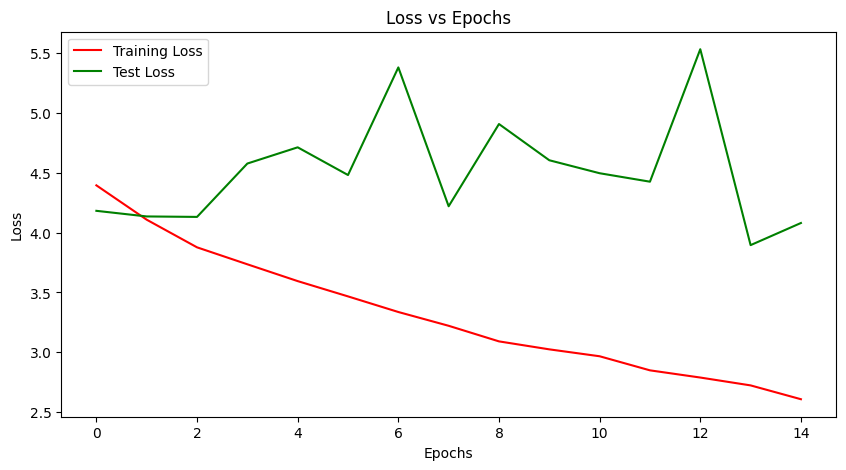

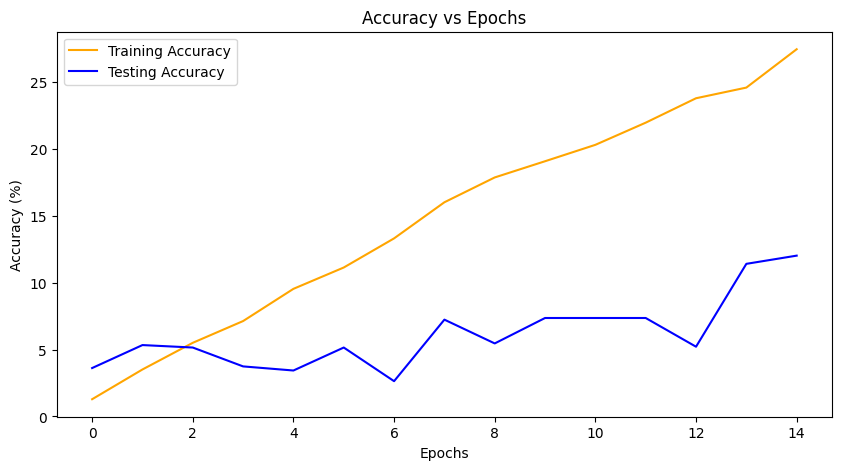

Final Test Loss: 4.0803, Final Test Accuracy: 12.03%
True: user001, Predicted: user012
True: user001, Predicted: user047
True: user001, Predicted: user047
True: user001, Predicted: user047
True: user001, Predicted: user008
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user012
True: user001, Predicted: user012
True: user001, Predicted: user054
True: user001, Predicted: user080
True: user001, Predicted: user017
True: user001, Predicted: user017
True: user001, Predicted: user017
True: user001, Predicted: user008
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user008
True: user001, Predicted: user008
True: user001, Predicted: user008
True: user002, Predicted: user050
True: user002, Predicted: user070
True: user002, Predicted: user002
True: user002, Predicted: user079
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user050
True: user002, Predicted: use

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Calculate the flattened size dynamically
        dummy_input = torch.zeros(1, 3, 150, 150)  # Dummy input with input image size
        self.feature_map_size = self._get_flatten_size(dummy_input)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flatten_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations with augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=10),               # Random rotation within ±10 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)), # Random scaling
    transforms.RandomAffine(degrees=0, shear=10),        # Random shearing
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5), # Random perspective distortion
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random illumination changes
    transforms.ToTensor(),                               # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test predictions function
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")



Key Enhancements:
1. Dropout increased to 50% for better regularization.
2. Learning rate scheduler (StepLR) to adjust the learning rate during training, improving the model's convergence.
3. AdamW optimizer for better weight decay regularization.
4. Increased the number of epochs for better convergence, allowing the model to train longer.

Epoch [1/20], Train Loss: 4.3594, Train Accuracy: 1.50%, Test Loss: 4.1037, Test Accuracy: 3.50%
Epoch [2/20], Train Loss: 4.0437, Train Accuracy: 3.99%, Test Loss: 3.8363, Test Accuracy: 7.49%
Epoch [3/20], Train Loss: 3.8209, Train Accuracy: 6.32%, Test Loss: 3.9123, Test Accuracy: 5.89%
Epoch [4/20], Train Loss: 3.6854, Train Accuracy: 8.03%, Test Loss: 4.3471, Test Accuracy: 4.85%
Epoch [5/20], Train Loss: 3.5624, Train Accuracy: 9.79%, Test Loss: 3.9913, Test Accuracy: 6.45%
Epoch [6/20], Train Loss: 3.3782, Train Accuracy: 12.23%, Test Loss: 4.2575, Test Accuracy: 6.32%
Epoch [7/20], Train Loss: 3.2751, Train Accuracy: 14.92%, Test Loss: 4.5886, Test Accuracy: 4.97%
Epoch [8/20], Train Loss: 3.1876, Train Accuracy: 15.58%, Test Loss: 4.0785, Test Accuracy: 6.94%
Epoch [9/20], Train Loss: 3.0924, Train Accuracy: 18.02%, Test Loss: 4.3146, Test Accuracy: 6.45%
Epoch [10/20], Train Loss: 3.0191, Train Accuracy: 18.85%, Test Loss: 4.3702, Test Accuracy: 6.63%
Epoch [11/20], Train Los

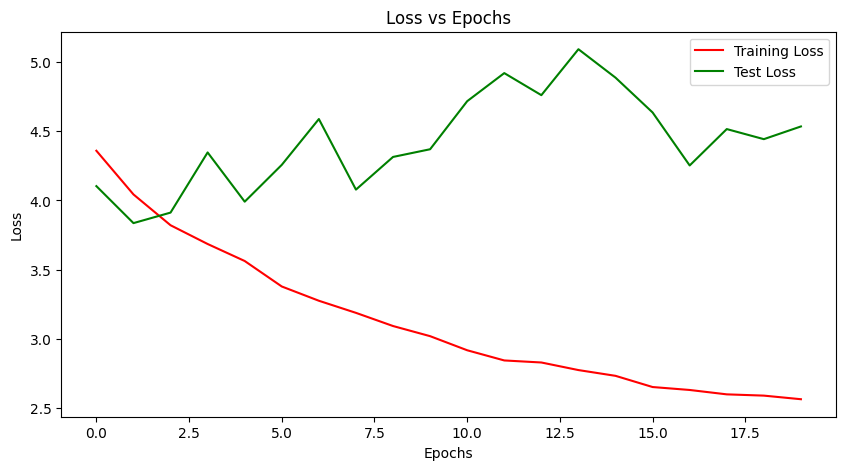

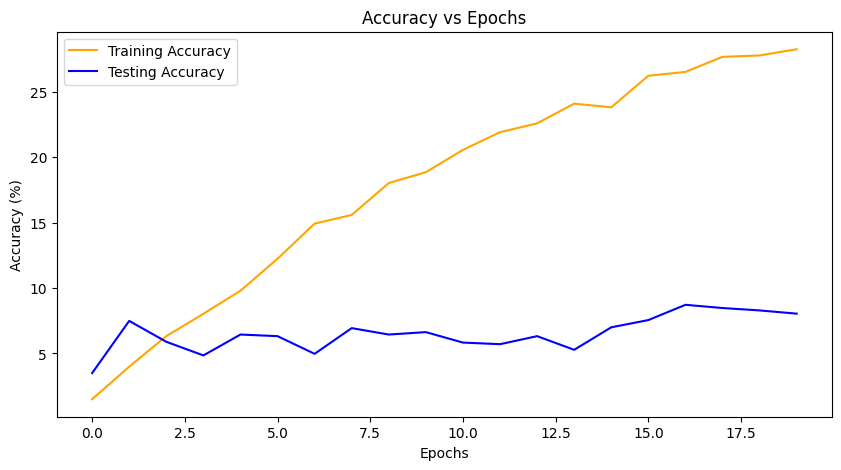

Final Test Loss: 4.5350, Final Test Accuracy: 8.04%
Model saved as custom_cnn.pth


In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.5)  # Increased dropout
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Calculate the flattened size dynamically
        dummy_input = torch.zeros(1, 3, 150, 150)  # Dummy input with input image size
        self.feature_map_size = self._get_flatten_size(dummy_input)

        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, 512)  # Increased neurons
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def _get_flatten_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))

        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)

        # Fully connected layers with dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations with augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=10),               # Random rotation within ±10 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)), # Random scaling
    transforms.RandomAffine(degrees=0, shear=10),        # Random shearing
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5), # Random perspective distortion
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random illumination changes
    transforms.ToTensor(),                               # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW optimizer for better regularization

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce learning rate every 5 epochs

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=20):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        # Step the learning rate scheduler
        scheduler.step()

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=20)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")


DROP OUT = 0.3

Epoch [1/15], Train Loss: 4.3342, Train Accuracy: 2.12%, Test Loss: 4.8499, Test Accuracy: 1.84%
Epoch [2/15], Train Loss: 4.0507, Train Accuracy: 4.08%, Test Loss: 4.1481, Test Accuracy: 3.68%
Epoch [3/15], Train Loss: 3.8439, Train Accuracy: 6.37%, Test Loss: 4.2163, Test Accuracy: 5.34%
Epoch [4/15], Train Loss: 3.7475, Train Accuracy: 7.37%, Test Loss: 4.0602, Test Accuracy: 5.22%
Epoch [5/15], Train Loss: 3.6401, Train Accuracy: 9.10%, Test Loss: 4.0721, Test Accuracy: 6.45%
Epoch [6/15], Train Loss: 3.5214, Train Accuracy: 10.54%, Test Loss: 4.5900, Test Accuracy: 4.79%
Epoch [7/15], Train Loss: 3.4192, Train Accuracy: 12.31%, Test Loss: 4.6905, Test Accuracy: 5.22%
Epoch [8/15], Train Loss: 3.3017, Train Accuracy: 13.91%, Test Loss: 3.8100, Test Accuracy: 7.24%
Epoch [9/15], Train Loss: 3.2289, Train Accuracy: 15.92%, Test Loss: 4.8306, Test Accuracy: 4.85%
Epoch [10/15], Train Loss: 3.1147, Train Accuracy: 17.08%, Test Loss: 4.6762, Test Accuracy: 4.54%
Epoch [11/15], Train Los

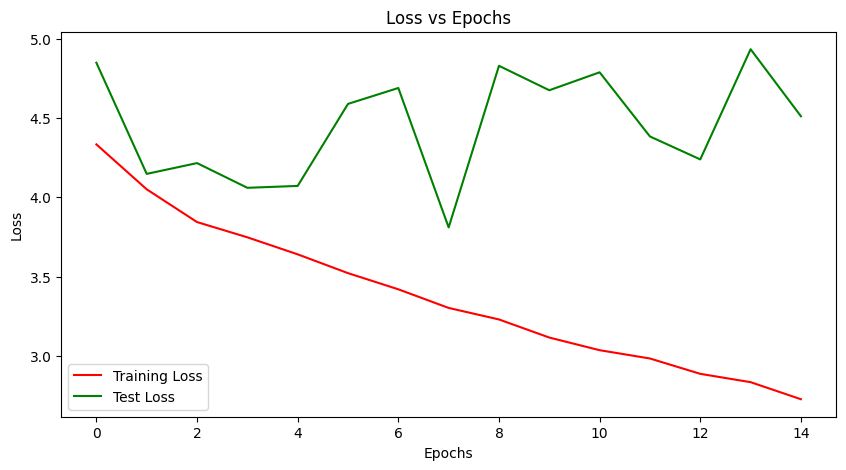

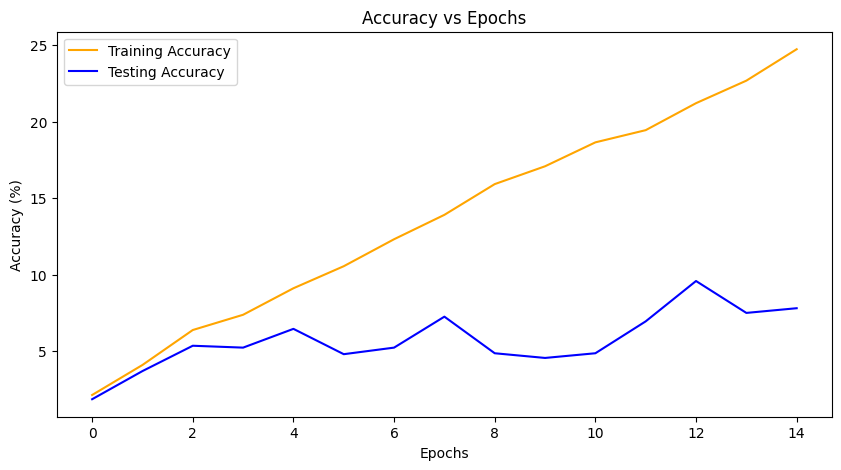

Final Test Loss: 4.5120, Final Test Accuracy: 7.80%
True: user001, Predicted: user009
True: user001, Predicted: user061
True: user001, Predicted: user061
True: user001, Predicted: user061
True: user001, Predicted: user009
True: user001, Predicted: user001
True: user001, Predicted: user008
True: user001, Predicted: user009
True: user001, Predicted: user009
True: user001, Predicted: user054
True: user001, Predicted: user012
True: user001, Predicted: user061
True: user001, Predicted: user017
True: user001, Predicted: user017
True: user001, Predicted: user056
True: user001, Predicted: user001
True: user001, Predicted: user012
True: user001, Predicted: user012
True: user001, Predicted: user009
True: user001, Predicted: user009
True: user002, Predicted: user070
True: user002, Predicted: user016
True: user002, Predicted: user002
True: user002, Predicted: user079
True: user002, Predicted: user016
True: user002, Predicted: user002
True: user002, Predicted: user079
True: user002, Predicted: user

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Calculate the flattened size dynamically
        dummy_input = torch.zeros(1, 3, 150, 150)  # Dummy input with input image size
        self.feature_map_size = self._get_flatten_size(dummy_input)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flatten_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Load datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations (augmentation)
transform = transforms.Compose([

    transforms.ToTensor(),  # Convert to Tensor
    transforms.RandomRotation(degrees=10),               # Random rotation within ±10 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)), # Random scaling
    transforms.RandomAffine(degrees=0, shear=10),        # Random shearing
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5), # Random perspective distortion
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random illumination changes
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])


# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.7)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Calculate the flattened size dynamically
        dummy_input = torch.zeros(1, 3, 150, 150)  # Dummy input with input image size
        self.feature_map_size = self._get_flatten_size(dummy_input)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flatten_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Load datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations (augmentation)
transform = transforms.Compose([

    transforms.ToTensor(),  # Convert to Tensor
    transforms.RandomRotation(degrees=10),               # Random rotation within ±10 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)), # Random scaling
    transforms.RandomAffine(degrees=0, shear=10),        # Random shearing
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5), # Random perspective distortion
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random illumination changes
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])


# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")

DROP OUT = 0.7

Epoch [1/15], Train Loss: 4.4251, Train Accuracy: 1.03%, Test Loss: 4.4073, Test Accuracy: 1.41%
Epoch [2/15], Train Loss: 4.4089, Train Accuracy: 1.18%, Test Loss: 4.4067, Test Accuracy: 1.23%
Epoch [3/15], Train Loss: 4.4084, Train Accuracy: 1.20%, Test Loss: 4.4061, Test Accuracy: 1.23%
Epoch [4/15], Train Loss: 4.4071, Train Accuracy: 1.06%, Test Loss: 4.4056, Test Accuracy: 1.23%
Epoch [5/15], Train Loss: 4.4068, Train Accuracy: 0.97%, Test Loss: 4.4053, Test Accuracy: 1.35%
Epoch [6/15], Train Loss: 4.4067, Train Accuracy: 1.01%, Test Loss: 4.4051, Test Accuracy: 1.23%
Epoch [7/15], Train Loss: 4.4066, Train Accuracy: 0.94%, Test Loss: 4.4050, Test Accuracy: 1.23%
Epoch [8/15], Train Loss: 4.4066, Train Accuracy: 1.07%, Test Loss: 4.4049, Test Accuracy: 1.23%
Epoch [9/15], Train Loss: 4.4064, Train Accuracy: 0.97%, Test Loss: 4.4049, Test Accuracy: 1.23%
Epoch [10/15], Train Loss: 4.4063, Train Accuracy: 0.94%, Test Loss: 4.4049, Test Accuracy: 1.96%
Epoch [11/15], Train Loss: 4.

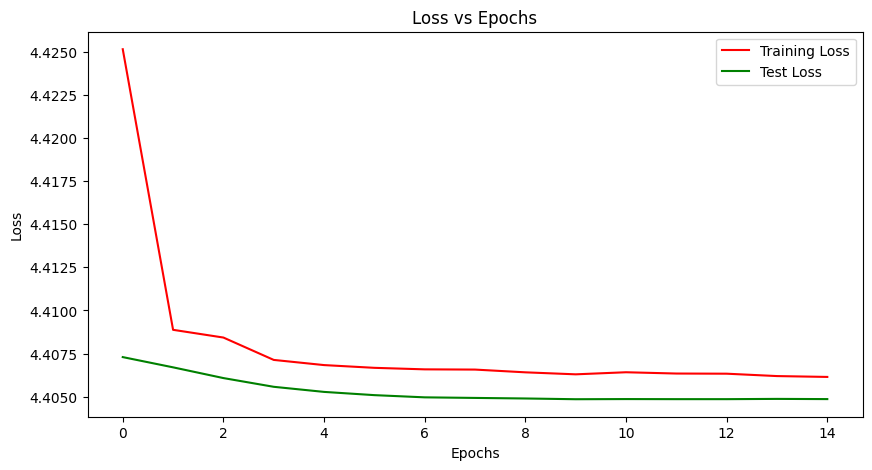

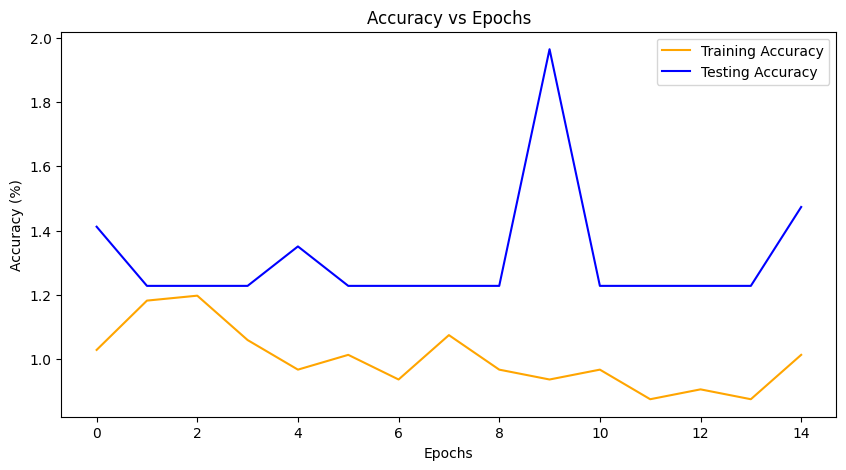

Final Test Loss: 4.4049, Final Test Accuracy: 1.47%
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user061
True: user001, Predicted: user061
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user001, Predicted: user006
True: user002, Predicted: user006
True: user002, Predicted: user061
True: user002, Predicted: user006
True: user002, Predicted: user006
True: user002, Predicted: user006
True: user002, Predicted: user061
True: user002, Predicted: user006
True: user002, Predicted: user

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.7)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Calculate the flattened size dynamically
        dummy_input = torch.zeros(1, 3, 150, 150)  # Dummy input with input image size
        self.feature_map_size = self._get_flatten_size(dummy_input)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flatten_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Load datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations (augmentation)
transform = transforms.Compose([

    transforms.ToTensor(),  # Convert to Tensor
    transforms.RandomRotation(degrees=10),               # Random rotation within ±10 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)), # Random scaling
    transforms.RandomAffine(degrees=0, shear=10),        # Random shearing
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5), # Random perspective distortion
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random illumination changes
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])


# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")

Epoch [1/15], Train Loss: 4.4014, Train Accuracy: 1.49%, Test Loss: 4.6644, Test Accuracy: 1.47%
Epoch [2/15], Train Loss: 4.3615, Train Accuracy: 1.64%, Test Loss: 4.1427, Test Accuracy: 3.07%
Epoch [3/15], Train Loss: 4.0344, Train Accuracy: 3.99%, Test Loss: 4.3143, Test Accuracy: 1.96%
Epoch [4/15], Train Loss: 3.8398, Train Accuracy: 5.88%, Test Loss: 3.7370, Test Accuracy: 7.24%
Epoch [5/15], Train Loss: 3.6996, Train Accuracy: 7.61%, Test Loss: 4.0448, Test Accuracy: 5.46%
Epoch [6/15], Train Loss: 3.5371, Train Accuracy: 9.95%, Test Loss: 3.8396, Test Accuracy: 7.61%
Epoch [7/15], Train Loss: 3.4085, Train Accuracy: 12.49%, Test Loss: 3.9706, Test Accuracy: 7.00%
Epoch [8/15], Train Loss: 3.2666, Train Accuracy: 15.56%, Test Loss: 3.5718, Test Accuracy: 10.68%
Epoch [9/15], Train Loss: 3.1566, Train Accuracy: 16.65%, Test Loss: 3.4917, Test Accuracy: 12.03%
Epoch [10/15], Train Loss: 3.0333, Train Accuracy: 19.08%, Test Loss: 4.4019, Test Accuracy: 5.77%
Epoch [11/15], Train Lo

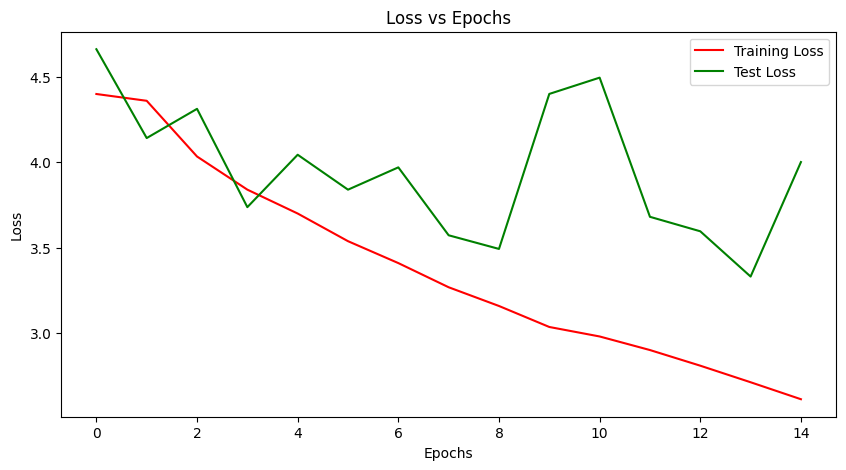

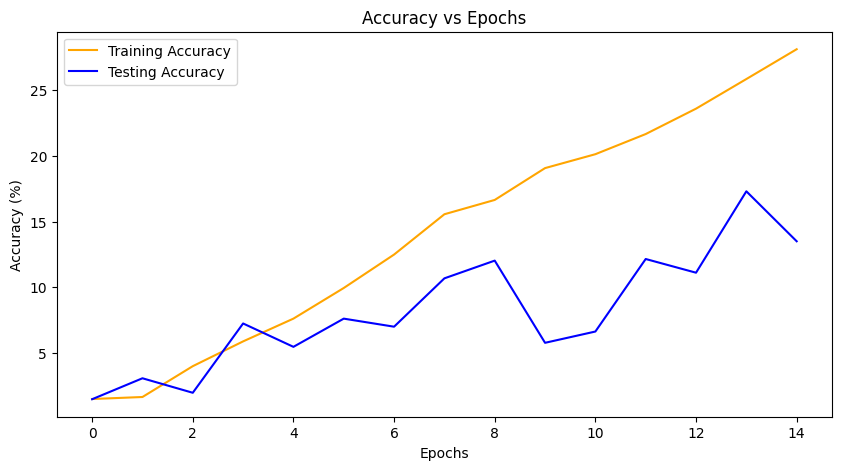

Final Test Loss: 4.0017, Final Test Accuracy: 13.51%
True: user001, Predicted: user012
True: user001, Predicted: user001
True: user001, Predicted: user056
True: user001, Predicted: user056
True: user001, Predicted: user079
True: user001, Predicted: user001
True: user001, Predicted: user008
True: user001, Predicted: user009
True: user001, Predicted: user009
True: user001, Predicted: user054
True: user001, Predicted: user012
True: user001, Predicted: user012
True: user001, Predicted: user032
True: user001, Predicted: user001
True: user001, Predicted: user008
True: user001, Predicted: user001
True: user001, Predicted: user009
True: user001, Predicted: user080
True: user001, Predicted: user008
True: user001, Predicted: user009
True: user002, Predicted: user032
True: user002, Predicted: user067
True: user002, Predicted: user002
True: user002, Predicted: user079
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user070
True: user002, Predicted: use

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers with adjusted filter size, stride, and padding
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)  # 5x5 filter, stride 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)  # 5x5 filter, stride 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 3x3 filter, stride 1
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)  # 5x5 filter, stride 2
        
        # Pooling layer (standard 2x2 max pooling after each convolution)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Calculate the flattened size dynamically
        dummy_input = torch.zeros(1, 3, 150, 150)  # Dummy input with input image size
        self.feature_map_size = self._get_flatten_size(dummy_input)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flatten_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Load datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations (augmentation)
transform = transforms.Compose([

    transforms.ToTensor(),  # Convert to Tensor
    transforms.RandomRotation(degrees=10),               # Random rotation within ±10 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)), # Random scaling
    transforms.RandomAffine(degrees=0, shear=10),        # Random shearing
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5), # Random perspective distortion
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random illumination changes
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])


# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")


Epoch [1/15], Train Loss: 4.3887, Train Accuracy: 1.32%, Test Loss: 4.3045, Test Accuracy: 1.78%
Epoch [2/15], Train Loss: 4.0970, Train Accuracy: 3.36%, Test Loss: 4.1294, Test Accuracy: 4.91%
Epoch [3/15], Train Loss: 3.8948, Train Accuracy: 5.89%, Test Loss: 3.9543, Test Accuracy: 5.77%
Epoch [4/15], Train Loss: 3.7681, Train Accuracy: 6.69%, Test Loss: 4.1010, Test Accuracy: 4.85%
Epoch [5/15], Train Loss: 3.6312, Train Accuracy: 9.04%, Test Loss: 4.2007, Test Accuracy: 4.54%
Epoch [6/15], Train Loss: 3.4607, Train Accuracy: 11.80%, Test Loss: 4.3259, Test Accuracy: 4.67%
Early stopping due to no improvement in validation accuracy.


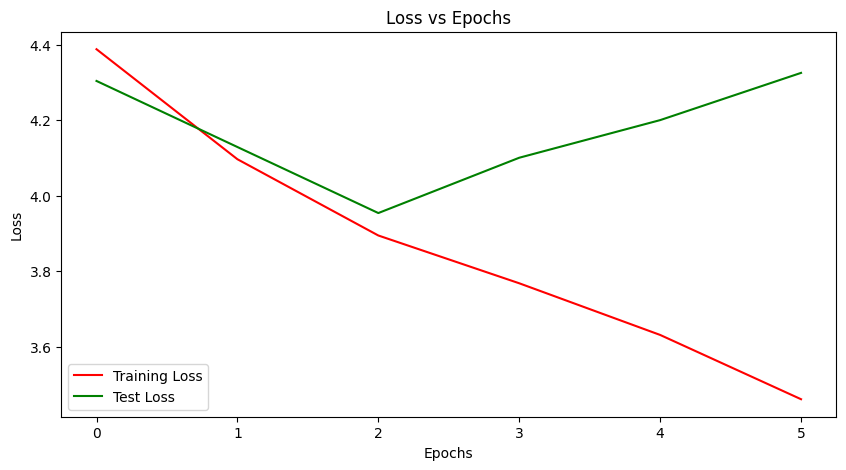

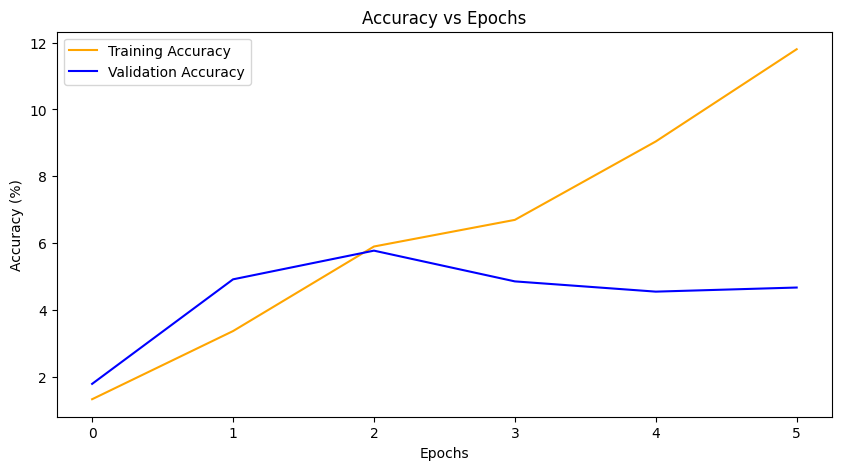

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers with adjusted filter size, stride, and padding
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)  # 5x5 filter, stride 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)  # 5x5 filter, stride 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 3x3 filter, stride 1
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)  # 5x5 filter, stride 2
        
        # Pooling layer (standard 2x2 max pooling after each convolution)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.5)  # Increased dropout to 0.5
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Calculate the flattened size dynamically
        dummy_input = torch.zeros(1, 3, 150, 150)  # Dummy input with input image size
        self.feature_map_size = self._get_flatten_size(dummy_input)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flatten_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations (augmentation)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.RandomRotation(degrees=10),  # Random rotation within ±10 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),  # Random scaling
    transforms.RandomAffine(degrees=0, shear=10),  # Random shearing
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Random perspective distortion
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random illumination changes
    transforms.RandomErasing(p=0.5),  # Random erasing for regularization
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training function with early stopping and improved monitoring
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=15):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_accuracy = 0.0
    patience = 3  # Early stopping patience (stop if no improvement in 3 epochs)
    patience_counter = 0
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
        
        # Early stopping
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            patience_counter = 0  # Reset patience counter if improvement
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping due to no improvement in validation accuracy.")
            break
        
        scheduler.step()  # Step the learning rate scheduler

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Validation Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=15)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)


TASK 3: VGGnet TRAINING

Epoch [1/15], Train Loss: 4.4077, Train Accuracy: 0.0101, Val Loss: 4.4067, Val Accuracy: 0.0123
Epoch [2/15], Train Loss: 4.4068, Train Accuracy: 0.0114, Val Loss: 4.4065, Val Accuracy: 0.0123
Epoch [3/15], Train Loss: 4.4069, Train Accuracy: 0.0098, Val Loss: 4.4064, Val Accuracy: 0.0123
Epoch [4/15], Train Loss: 4.4066, Train Accuracy: 0.0103, Val Loss: 4.4062, Val Accuracy: 0.0123
Epoch [5/15], Train Loss: 4.4065, Train Accuracy: 0.0101, Val Loss: 4.4059, Val Accuracy: 0.0123
Epoch [6/15], Train Loss: 4.4064, Train Accuracy: 0.0107, Val Loss: 4.4057, Val Accuracy: 0.0123
Epoch [7/15], Train Loss: 4.4062, Train Accuracy: 0.0094, Val Loss: 4.4054, Val Accuracy: 0.0123
Epoch [8/15], Train Loss: 4.4066, Train Accuracy: 0.0112, Val Loss: 4.4054, Val Accuracy: 0.0123
Epoch [9/15], Train Loss: 4.4060, Train Accuracy: 0.0107, Val Loss: 4.4053, Val Accuracy: 0.0123
Epoch [10/15], Train Loss: 4.4059, Train Accuracy: 0.0123, Val Loss: 4.4051, Val Accuracy: 0.0123
Epoch [11/15], Train Loss: 4.

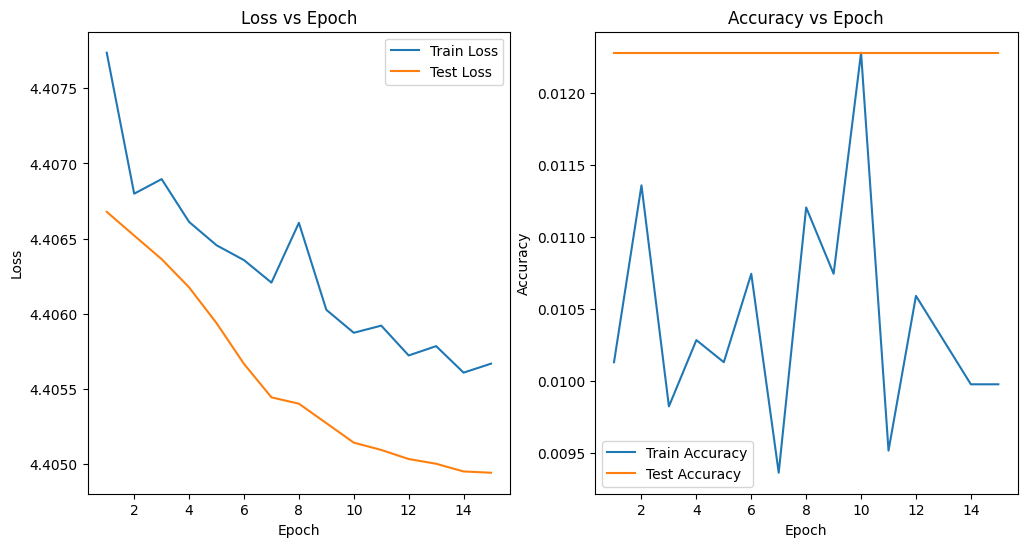

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. Load the VGG16 model without pre-trained weights
model = torchvision.models.vgg16(pretrained=False)  # pretrained=False to train from scratch

# Modify the final fully connected layer to match the number of classes in your dataset
num_classes = 82  
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 2. Data Augmentation and DataLoader
# Data transformations (augmentation)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.RandomRotation(degrees=10),  # Random rotation within ±10 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),  # Random scaling
    transforms.RandomAffine(degrees=0, shear=10),  # Random shearing
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Random perspective distortion
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random illumination changes
    transforms.RandomErasing(p=0.5),  # Random erasing for regularization
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Prepare the training dataset and DataLoader
train_dataset = datasets.ImageFolder(root='/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Prepare the validation dataset and DataLoader (without augmentation)
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_dataset = datasets.ImageFolder(root='/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test', transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 3. Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 4. Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Record the training loss and accuracy for this epoch
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Record the validation loss and accuracy for this epoch
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_accuracy = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# 5. Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=15
)

# 6. Plot Loss vs Epoch and Accuracy vs Epoch
plt.figure(figsize=(12, 6))

# Plot Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Test Loss')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Test Accuracy')
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define the data augmentation and transformations
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the training and validation datasets and dataloaders
train_data = datasets.ImageFolder(root='/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train', transform=transform)
val_data = datasets.ImageFolder(root='/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test', transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer for your dataset
num_features = model.fc.in_features
num_classes = len(train_data.classes)  # Number of classes in your dataset
model.fc = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define lists to store loss and accuracy values
train_loss_values = []
train_accuracy_values = []
val_accuracy_values = []

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Store training loss and accuracy values
    train_loss_values.append(running_loss / len(train_loader))
    train_accuracy_values.append(100 * correct / total)

    # Validation accuracy
    model.eval()  # Switch to evaluation mode
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total  # Calculate validation accuracy
    val_accuracy_values.append(val_accuracy)  # Store validation accuracy for plotting

    # Print the results for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {100 * correct / total:.2f}%, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

# Plotting Loss and Accuracy vs. Epoch
plt.figure(figsize=(12, 6))

# Plot Loss vs Epoch (Training)
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_values, label='Training Loss', color='red')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy vs Epoch (Training and Validation)
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_values, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracy_values, label='Test Accuracy', color='green')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


KeyboardInterrupt: 

Epoch [1/10], Train Loss: 4.3353, Train Accuracy: 2.2563, Val Loss: 5.9256, Val Accuracy: 1.2277
Epoch [2/10], Train Loss: 4.0984, Train Accuracy: 3.8833, Val Loss: 7.0300, Val Accuracy: 1.2277
Epoch [3/10], Train Loss: 3.9849, Train Accuracy: 5.2494, Val Loss: 8.5574, Val Accuracy: 1.2277
Epoch [4/10], Train Loss: 3.9133, Train Accuracy: 5.6946, Val Loss: 13.2086, Val Accuracy: 1.2277
Epoch [5/10], Train Loss: 3.8315, Train Accuracy: 7.3216, Val Loss: 8.5836, Val Accuracy: 1.2277
Epoch [6/10], Train Loss: 3.6826, Train Accuracy: 9.1635, Val Loss: 11.9781, Val Accuracy: 1.2277
Epoch [7/10], Train Loss: 3.5681, Train Accuracy: 11.3891, Val Loss: 15.4357, Val Accuracy: 1.6575
Epoch [8/10], Train Loss: 3.4453, Train Accuracy: 13.0468, Val Loss: 18.5529, Val Accuracy: 1.1664
Epoch [9/10], Train Loss: 3.3392, Train Accuracy: 14.9501, Val Loss: 7.6152, Val Accuracy: 1.6575
Epoch [10/10], Train Loss: 3.2685, Train Accuracy: 17.0683, Val Loss: 12.3698, Val Accuracy: 1.2277


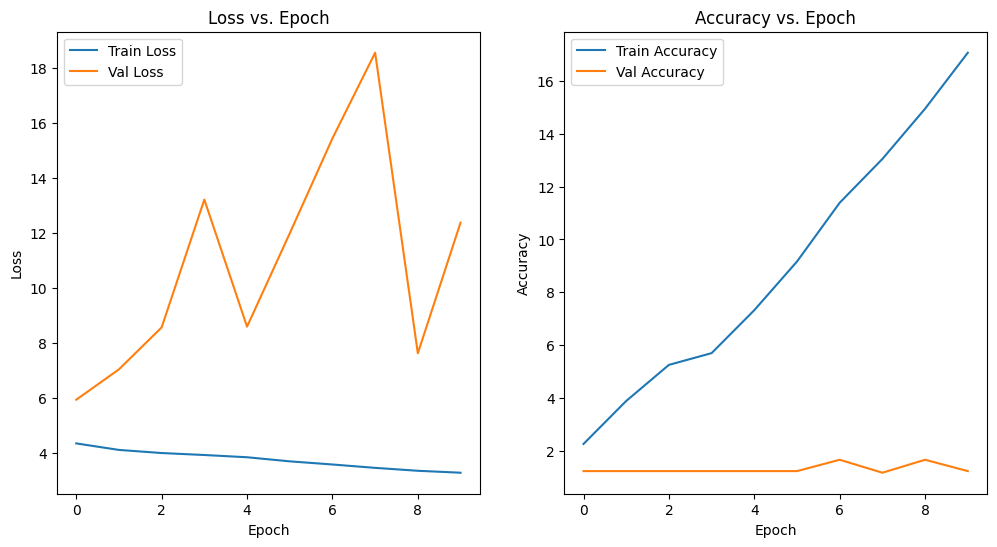

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define the data augmentation and transformations
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the training and validation datasets and dataloaders
train_data = datasets.ImageFolder(root='/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train', transform=transform)
val_data = datasets.ImageFolder(root='/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test', transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=False)  # No pre-trained weights

# Modify the final fully connected layer for your dataset
num_features = model.fc.in_features
num_classes = len(train_data.classes)  # Number of classes in your dataset
model.fc = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define lists to store loss and accuracy values
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

    # Print the results in the desired format
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plotting Loss vs Epoch and Accuracy vs Epoch
plt.figure(figsize=(12, 6))

# Plot Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Val Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values, label='Train Accuracy')
plt.plot(val_accuracy_values, label='Val Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


############################  HERE IS TASK 3 #############################

Epoch [1/15], Train Loss: 4.3265, Train Accuracy: 2.3177, Test Loss: 5.6442, Test Accuracy: 1.2277
Epoch [2/15], Train Loss: 4.0785, Train Accuracy: 4.4206, Test Loss: 10.3624, Test Accuracy: 1.2277
Epoch [3/15], Train Loss: 3.9577, Train Accuracy: 5.3108, Test Loss: 12.6826, Test Accuracy: 1.2277
Epoch [4/15], Train Loss: 3.8358, Train Accuracy: 7.6439, Test Loss: 11.1622, Test Accuracy: 1.2277
Epoch [5/15], Train Loss: 3.6830, Train Accuracy: 9.3937, Test Loss: 14.4474, Test Accuracy: 1.2277
Epoch [6/15], Train Loss: 3.5506, Train Accuracy: 11.3891, Test Loss: 11.2219, Test Accuracy: 1.9644
Epoch [7/15], Train Loss: 3.4464, Train Accuracy: 12.6631, Test Loss: 20.2923, Test Accuracy: 1.2277
Epoch [8/15], Train Loss: 3.3206, Train Accuracy: 15.1343, Test Loss: 13.8299, Test Accuracy: 1.2277
Epoch [9/15], Train Loss: 3.2316, Train Accuracy: 16.9762, Test Loss: 16.8386, Test Accuracy: 1.2891
Epoch [10/15], Train Loss: 3.1106, Train Accuracy: 19.5856, Test Loss: 25.7328, Test Accuracy: 1.

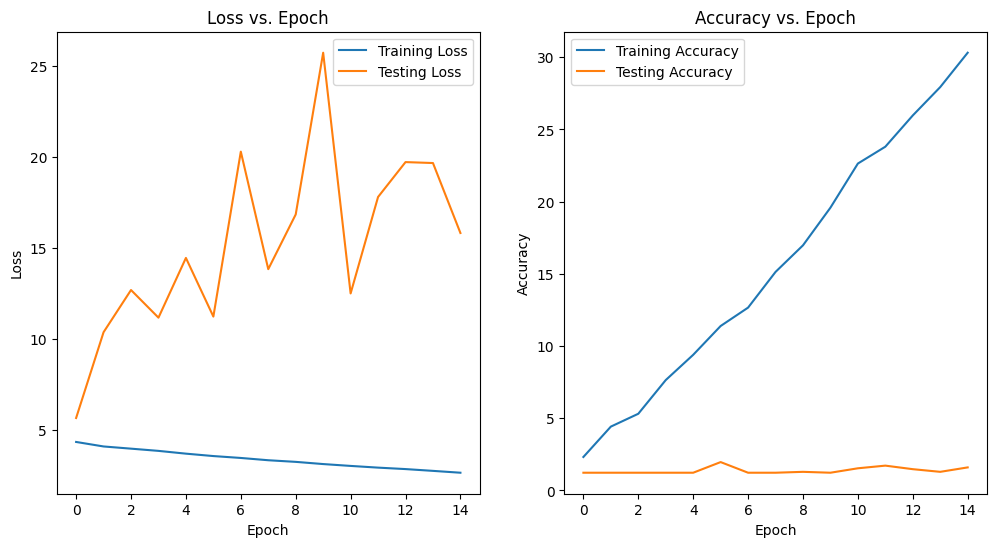

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define the data augmentation and transformations
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the training and validation datasets and dataloaders
train_data = datasets.ImageFolder(root='/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train', transform=transform)
val_data = datasets.ImageFolder(root='/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test', transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=False)  # No pre-trained weights

# Modify the final fully connected layer for your dataset
num_features = model.fc.in_features
num_classes = len(train_data.classes)  # Number of classes in your dataset
model.fc = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define lists to store loss and accuracy values
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

# Training loop
num_epochs = 15  # Change the number of epochs to 15
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Save the predictions and labels for displaying
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation loss and accuracy
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

    # Print the results in the desired format
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}")


# Plotting Loss vs Epoch and Accuracy vs Epoch
plt.figure(figsize=(12, 6))

# Plot Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Testing Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Testing Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###########################################################################

Epoch [1/15], Train Loss: 4.2976, Train Accuracy: 2.87%, Test Loss: 6.4035, Test Accuracy: 1.23%
Epoch [2/15], Train Loss: 4.0967, Train Accuracy: 3.90%, Test Loss: 8.8000, Test Accuracy: 1.23%
Epoch [3/15], Train Loss: 3.9472, Train Accuracy: 5.99%, Test Loss: 8.5487, Test Accuracy: 1.23%
Epoch [4/15], Train Loss: 3.7723, Train Accuracy: 9.09%, Test Loss: 10.8348, Test Accuracy: 1.23%
Epoch [5/15], Train Loss: 3.6135, Train Accuracy: 10.96%, Test Loss: 8.9233, Test Accuracy: 1.23%
Epoch [6/15], Train Loss: 3.4526, Train Accuracy: 13.69%, Test Loss: 17.1769, Test Accuracy: 1.23%
Epoch [7/15], Train Loss: 3.3140, Train Accuracy: 16.33%, Test Loss: 12.0073, Test Accuracy: 1.17%
Epoch [8/15], Train Loss: 3.1921, Train Accuracy: 18.08%, Test Loss: 14.4710, Test Accuracy: 1.23%
Epoch [9/15], Train Loss: 3.0529, Train Accuracy: 20.68%, Test Loss: 17.1269, Test Accuracy: 1.41%
Epoch [10/15], Train Loss: 2.9466, Train Accuracy: 23.76%, Test Loss: 14.6172, Test Accuracy: 0.92%
Epoch [11/15], Tr

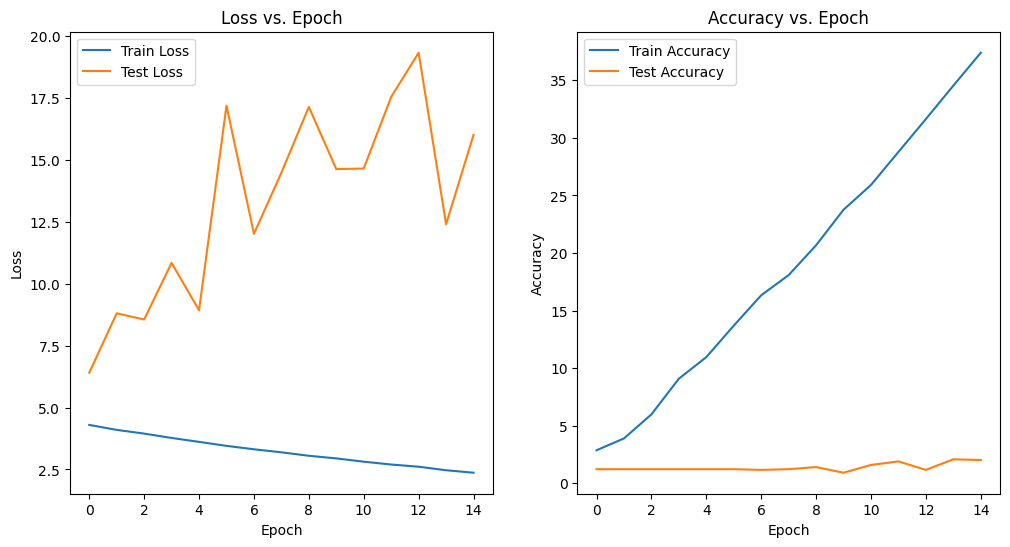

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define the data augmentation and transformations
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the training and validation datasets and dataloaders
train_data = datasets.ImageFolder(root='/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train', transform=transform)
val_data = datasets.ImageFolder(root='/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test', transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=False)  # No pre-trained weights

# Modify the final fully connected layer for your dataset
num_features = model.fc.in_features
num_classes = len(train_data.classes)  # Number of classes in your dataset
model.fc = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define lists to store loss and accuracy values
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Store training loss and accuracy values
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    # Validation phase (calculate loss and accuracy)
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

    # Print the results for the current epoch (including train and validation loss/accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.2f}%")

# Plotting Loss vs Epoch and Accuracy vs Epoch
plt.figure(figsize=(12, 6))

# Plot Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Test Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values, label='Train Accuracy')
plt.plot(val_accuracy_values, label='Test Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


TASK#3 WITH EPOCHS = 50

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define the data augmentation and transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the training and validation datasets and dataloaders
train_data = datasets.ImageFolder(root='/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train', transform=transform)
val_data = datasets.ImageFolder(root='/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test', transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=False)  # No pre-trained weights

# Modify the final fully connected layer for your dataset
num_features = model.fc.in_features
num_classes = len(train_data.classes)  # Number of classes in your dataset
model.fc = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define lists to store loss and accuracy values
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Train phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

    # Print the results for the current epoch (including train and validation loss/accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.2f}%")

# Plotting Loss vs Epoch and Accuracy vs Epoch
plt.figure(figsize=(12, 6))

# Plot Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Test Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values, label='Train Accuracy')
plt.plot(val_accuracy_values, label='Test Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluation on validation set for predictions (optional)
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Call the function to print all predictions (optional)
test_predictions(model, val_loader, train_data.classes)


Epoch [1/10], Train Loss: 4.3464, Train Accuracy: 2.15%, Val Loss: 5.7157, Test Accuracy: 1.23%
Epoch [2/10], Train Loss: 4.1366, Train Accuracy: 3.58%, Val Loss: 10.2358, Test Accuracy: 1.23%


KeyboardInterrupt: 

############# TASK 4 ################

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define a simple convolutional neural network model
class CNNModel(nn.Module):
    def _init_(self):
        super(CNNModel, self)._init_()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Dynamically calculate the input size to the first linear layer
        self.flatten = nn.Flatten()
        self._initialize_fc_layers()

    def _initialize_fc_layers(self):
        # Create a dummy input to determine the size of the flattened tensor
        dummy_input = torch.zeros(1, 3, 64, 64)  # Assuming input images are 64x64
        out = self.conv_layers(dummy_input)
        flattened_size = out.numel()  # Total number of elements after flattening
        
        self.fc1 = nn.Linear(flattened_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x


# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations (no augmentation)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model setup
model = CNNModel()  # Using the custom CNNModel class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test the model on all samples and print predictions
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "sequential_model.pth")
print("Model saved as sequential_model.pth")


ValueError: optimizer got an empty parameter list

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
from PIL import Image

# Load AHAWP dataset function
def load_data():
    dataset_path = '/kaggle/input/ahawp-per-user/kaggle/isolated_words_per_user/isolated_words_per_user'  # Path to AHAWP dataset
    images = []
    labels = []

    # Assuming the AHAWP dataset has directories for each writer
    for label_dir in os.listdir(dataset_path):
        writer_dir = os.path.join(dataset_path, label_dir)
        if os.path.isdir(writer_dir):
            for image_file in os.listdir(writer_dir):
                image_path = os.path.join(writer_dir, image_file)
                img = Image.open(image_path).convert('L')
                img = img.resize((28, 28))
                img_array = np.array(img)
                images.append(img_array)
                labels.append(label_dir)  # Writer ID as label

    images = np.array(images)
    labels = np.array(labels)

    # Convert labels to numeric values
    writer_labels = {label: idx for idx, label in enumerate(np.unique(labels.cpu() if isinstance(labels, torch.Tensor) else labels))}
    labels = np.array([writer_labels[label] for label in labels])

    # Normalize images
    images = images / 255.0
    images = images.reshape(images.shape[0], 28, 28, 1)

    # Split data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size=0.9, stratify=labels)

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=len(writer_labels))
    y_test = to_categorical(y_test, num_classes=len(writer_labels))


    return x_train, x_test, y_train, y_test

def preprocessing(x_train, x_test):
    return x_train, x_test  # Already normalized in load_data

# Load and preprocess data
x_train, x_test, y_train, y_test = load_data()

# Image Data Generator (augmentation)
generator = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)

# Define Keras CNN model
model = Sequential([
    Conv2D(filters=32, kernel_size=3, input_shape=(28, 28, 1), activation="relu"),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=3, activation="relu"),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=5, strides=2, padding="same", activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    Conv2D(filters=64, kernel_size=3, activation="relu"),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, activation="relu"),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    Conv2D(128, kernel_size=4, activation="relu"),
    BatchNormalization(),
    Flatten(),
    Dropout(0.4),
    Dense(len(np.unique(labels)), activation="softmax")  # Output layer for writer classification
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train model
history = model.fit(generator.flow(x_train, y_train, batch_size=64), epochs=30, steps_per_epoch=x_train.shape[0] // 64, validation_data=(x_test, y_test))

# Evaluate model
def evaluate_model():
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

evaluate_model()

# Plot training curves
def plot_training_curves():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='orange')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_curves()

# Save the trained model
model.save("keras_cnn_model_ahawp.h5")
print("Model saved as keras_cnn_model_ahawp.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
class CNNModel(nn.Module):
    def _init_(self):
        super(CNNModel, self)._init_()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Dynamically calculate the input size to the first linear layer
        self.flatten = nn.Flatten()
        self._initialize_fc_layers()

    def _initialize_fc_layers(self):
        # Create a dummy input to determine the size of the flattened tensor
        dummy_input = torch.zeros(1, 3, 64, 64)  # Assuming input images are 64x64
        out = self.conv_layers(dummy_input)
        flattened_size = out.numel()  # Total number of elements after flattening
        
        self.fc1 = nn.Linear(flattened_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models import ResNet18_Weights

# Define dataset paths
train_dir =  r"/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
val_dir = r"/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"


# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for pretrained models
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained model normalization
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pretrained model
model = models.resnet18(ResNet18_Weights.DEFAULT)  # Example with ResNet-18
num_classes = len(train_dataset.classes)

# Modify the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = running_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=10
)

# Plot Loss and Accuracy
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    # Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='red')
    plt.plot(val_losses, label='Validation Loss', color='blue')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy', color='orange')
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Save the model
torch.save(model.state_dict(), "fine_tuned_model.pth")
print("Model saved as fine_tuned_model.pth")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

TASK2 DATA AUGMENTATION WITH EPOCHS = 100

Epoch [1/100], Train Loss: 4.4160, Train Accuracy: 1.21%, Test Loss: 4.3969, Test Accuracy: 1.29%
Epoch [2/100], Train Loss: 4.2526, Train Accuracy: 2.03%, Test Loss: 4.1824, Test Accuracy: 3.01%
Epoch [3/100], Train Loss: 3.9935, Train Accuracy: 4.30%, Test Loss: 4.2969, Test Accuracy: 3.62%
Epoch [4/100], Train Loss: 3.8217, Train Accuracy: 6.12%, Test Loss: 3.9671, Test Accuracy: 4.60%
Epoch [5/100], Train Loss: 3.6777, Train Accuracy: 8.14%, Test Loss: 4.2858, Test Accuracy: 4.24%
Epoch [6/100], Train Loss: 3.5568, Train Accuracy: 9.58%, Test Loss: 4.1592, Test Accuracy: 5.03%
Epoch [7/100], Train Loss: 3.4155, Train Accuracy: 12.19%, Test Loss: 3.7524, Test Accuracy: 6.57%
Epoch [8/100], Train Loss: 3.3065, Train Accuracy: 14.03%, Test Loss: 4.4361, Test Accuracy: 5.89%
Epoch [9/100], Train Loss: 3.1958, Train Accuracy: 15.50%, Test Loss: 5.0161, Test Accuracy: 5.40%
Epoch [10/100], Train Loss: 3.1306, Train Accuracy: 16.52%, Test Loss: 3.9910, Test Accuracy: 8.04%
Epoch [11/100],

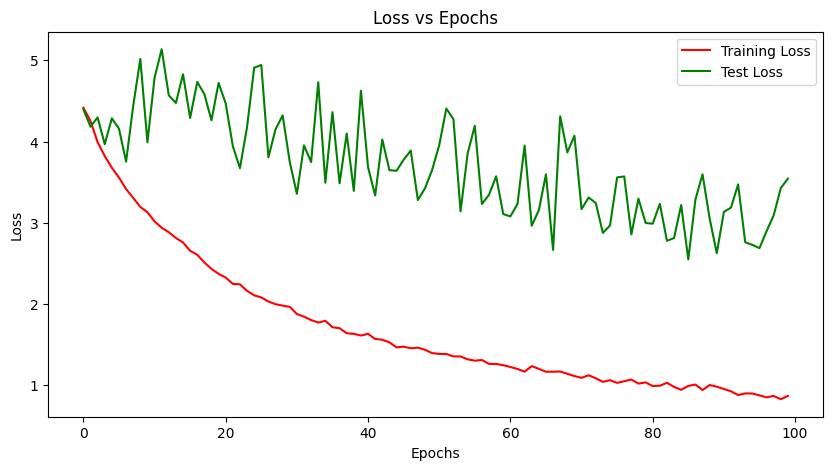

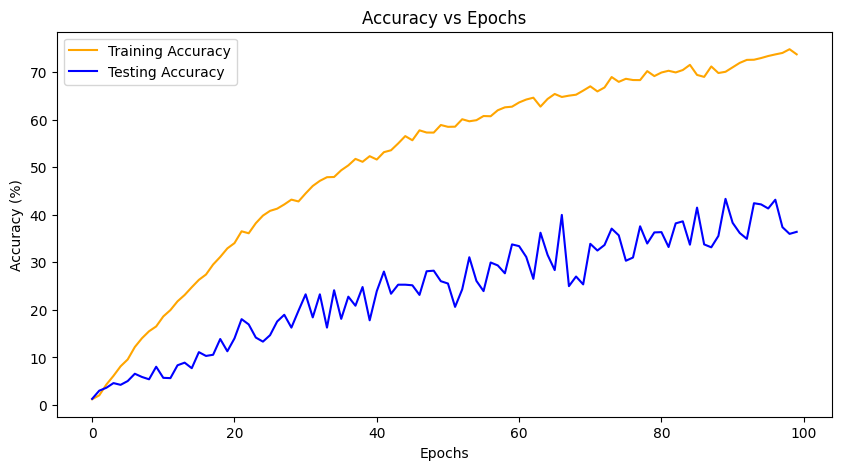

Final Test Loss: 3.5443, Final Test Accuracy: 36.40%
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user012
True: user001, Predicted: user012
True: user001, Predicted: user012
True: user001, Predicted: user012
True: user001, Predicted: user019
True: user001, Predicted: user056
True: user001, Predicted: user056
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user012
True: user001, Predicted: user006
True: user001, Predicted: user001
True: user002, Predicted: user079
True: user002, Predicted: user079
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user079
True: user002, Predicted: use

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Calculate the flattened size dynamically
        dummy_input = torch.zeros(1, 3, 150, 150)  # Dummy input with input image size
        self.feature_map_size = self._get_flatten_size(dummy_input)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flatten_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations with augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=10),               # Random rotation within ±10 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)), # Random scaling
    transforms.RandomAffine(degrees=0, shear=10),        # Random shearing
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5), # Random perspective distortion
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random illumination changes
    transforms.ToTensor(),                               # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test predictions function
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=15)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
print("Model saved as custom_cnn.pth")



TASK2 DATA AUGMENTATION WITH EPOCHS = 150 ------- WE WANT IT ---------

Epoch [1/150], Train Loss: 4.4044, Train Accuracy: 1.24%, Test Loss: 4.3473, Test Accuracy: 2.21%
Epoch [2/150], Train Loss: 4.1188, Train Accuracy: 3.33%, Test Loss: 3.9646, Test Accuracy: 5.83%
Epoch [3/150], Train Loss: 3.8834, Train Accuracy: 6.05%, Test Loss: 3.8497, Test Accuracy: 7.55%
Epoch [4/150], Train Loss: 3.7516, Train Accuracy: 7.37%, Test Loss: 3.8486, Test Accuracy: 7.31%
Epoch [5/150], Train Loss: 3.6344, Train Accuracy: 8.96%, Test Loss: 3.8122, Test Accuracy: 7.06%
Epoch [6/150], Train Loss: 3.4770, Train Accuracy: 11.22%, Test Loss: 3.8586, Test Accuracy: 4.91%
Epoch [7/150], Train Loss: 3.3882, Train Accuracy: 12.85%, Test Loss: 4.5067, Test Accuracy: 5.77%
Epoch [8/150], Train Loss: 3.2566, Train Accuracy: 14.98%, Test Loss: 3.6969, Test Accuracy: 8.96%
Epoch [9/150], Train Loss: 3.1696, Train Accuracy: 16.10%, Test Loss: 4.3769, Test Accuracy: 6.14%
Epoch [10/150], Train Loss: 3.0497, Train Accuracy: 18.34%, Test Loss: 4.6704, Test Accuracy: 6.51%
Epoch [11/150]

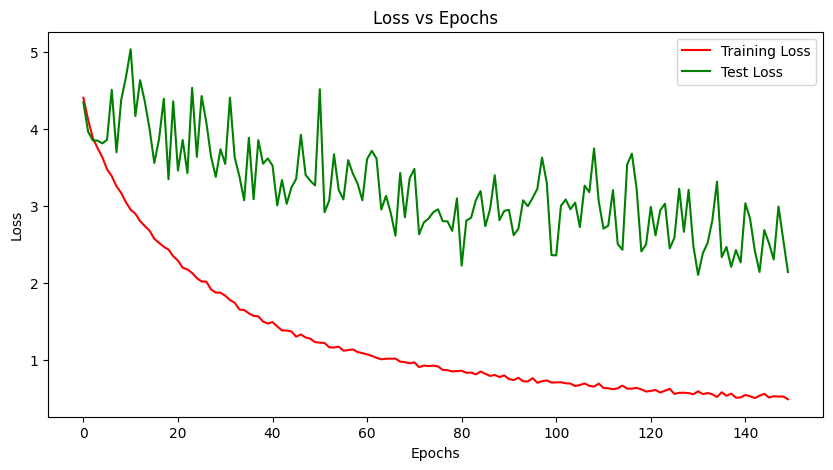

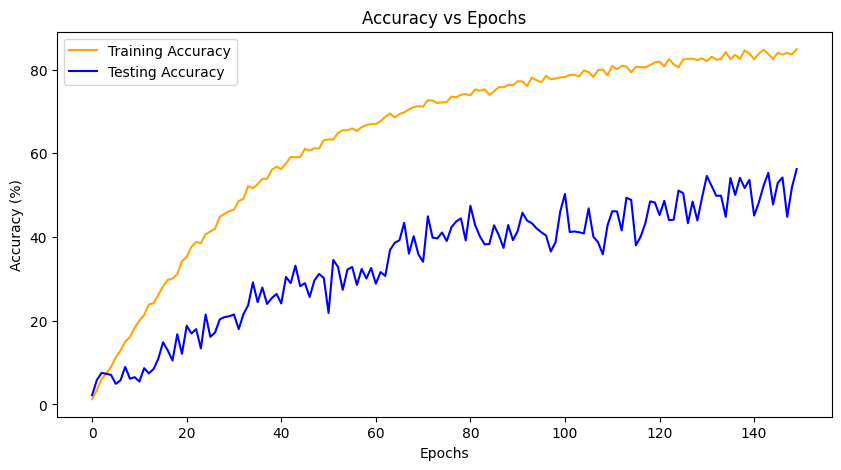

Final Test Loss: 2.1449, Final Test Accuracy: 56.23%
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user019
True: user001, Predicted: user006
True: user001, Predicted: user054
True: user001, Predicted: user019
True: user001, Predicted: user056
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user001, Predicted: user008
True: user001, Predicted: user001
True: user001, Predicted: user001
True: user002, Predicted: user079
True: user002, Predicted: user072
True: user002, Predicted: user002
True: user002, Predicted: user021
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: user002
True: user002, Predicted: use

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout and Batch Normalization
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Calculate the flattened size dynamically
        dummy_input = torch.zeros(1, 3, 150, 150)  # Dummy input with input image size
        self.feature_map_size = self._get_flatten_size(dummy_input)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flatten_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with pooling and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        
        # Flatten feature maps
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define paths to datasets
train_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/train"
test_dir = "/kaggle/input/ahawp-splitting-to-train-and-test/AHAWP_splitting_to_train_and_test/test"

# Data transformations with augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=10),               # Random rotation within ±10 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)), # Random scaling
    transforms.RandomAffine(degrees=0, shear=10),        # Random shearing
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5), # Random perspective distortion
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random illumination changes
    transforms.ToTensor(),                               # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    all_test_accuracies = []  # To store test accuracies for all epochs

    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluate after each epoch
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        val_accuracies.append(accuracy)
        all_test_accuracies.append(accuracy)  # Append test accuracy for this epoch

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {100 * correct_train / total_train:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    # Calculate average test accuracy
    average_test_accuracy = sum(all_test_accuracies) / len(all_test_accuracies)
    print(f"Average Test Accuracy over {epochs} epochs: {average_test_accuracy:.2f}%")

    return train_losses, test_losses, train_accuracies, val_accuracies, average_test_accuracy


    

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Test predictions function
def test_predictions(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                print(f"True: {class_names[labels[i]]}, Predicted: {class_names[predicted[i]]}")

# Plot training curves
def plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(val_accuracies, label='Testing Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Train the model

# Train the model
train_losses, test_losses, train_accuracies, val_accuracies, avg_test_accuracy = train_model(
    model, train_loader, test_loader, criterion, optimizer, epochs=150
)
#train_losses, test_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100)

# Plot the training curves
plot_training_curves(train_losses, test_losses, train_accuracies, val_accuracies)

# Evaluate the final test accuracy
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%")

# Call the function to print all predictions
test_predictions(model, test_loader, train_dataset.classes)

# Save the trained model
torch.save(model.state_dict(), "custom_cnn.pth")
# Display the average test accuracy
print(f"Average Test Accuracy: {avg_test_accuracy:.2f}%")

print("Model saved as custom_cnn.pth")

